# AirBnb Listings Analysis

## Basic Exploration

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

In [2]:
# Loading data
listings = pd.read_csv('listings.csv')  # go up one directory
listings.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,29059.0,https://www.airbnb.com/rooms/29059,2.025060e+13,6/27/25,city scrape,Lovely studio Quartier Latin,CITQ 267153<br />Lovely studio with 1 closed r...,CENTRAL is the watchword: everything is close....,https://a0.muscache.com/pictures/736399/fa6c31...,125031,...,4.78,4.82,4.67,"Quebec - Registration number<br />267153, expi...",f,2,2,0,0,2.66
1,29061.0,https://www.airbnb.com/rooms/29061,2.025060e+13,6/26/25,city scrape,Maison historique - Quartier Latin,Lovely historic house with plenty of period ch...,The neighborhood you'll discover is called the...,https://a0.muscache.com/pictures/9e59d417-4b6a...,125031,...,4.83,4.87,4.72,"Quebec - Registration number<br />267153, expi...",f,2,2,0,0,0.96
2,36301.0,https://www.airbnb.com/rooms/36301,2.025060e+13,6/26/25,city scrape,Romantic & peaceful Plateau loft,"Enjoy the best of Montreal in this romantic, ...",The neighborhood is very lively while the stre...,https://a0.muscache.com/pictures/26c20544-475f...,381468,...,4.90,4.88,4.77,NaN,f,8,8,0,0,0.42
3,38118.0,https://www.airbnb.com/rooms/38118,2.025060e+13,6/26/25,city scrape,Beautiful room with a balcony in front of a parc,Nearest metro Papineau. Situated in front of P...,NaN,https://a0.muscache.com/pictures/213997/763ec1...,163569,...,4.82,4.65,4.41,NaN,f,3,0,3,0,0.10
4,50479.0,https://www.airbnb.com/rooms/50479,2.025060e+13,6/26/25,city scrape,L'Arcade Douce,The appartement is sunny and ideally situated ...,Our area is full of life (but our street is qu...,https://a0.muscache.com/pictures/airflow/Hosti...,231694,...,4.99,4.85,4.93,"Quebec - Registration number<br />271530, expi...",t,2,1,1,0,1.90


In [3]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
# Get the amenity string for the first row (index 0)
amenity_string = listings.loc[0, 'amenities']

# Print the full string to see what it looks like
print(f"Full amenity string: {amenity_string}")

# Clean the string by removing the outer brackets
cleaned_string = amenity_string.strip('[]')

# Check if the string is empty after stripping (i.e., it was just "[]")
if not cleaned_string:
    count = 0
else:
    # Split the string by commas to get a list of amenities
    amenity_list = cleaned_string.split(',')
    # Get the length of the list
    count = len(amenity_list)

print(f"Number of amenities: {count}")

Full amenity string: ["Hair dryer", "Hot water kettle", "Crib - available upon request", "Conditioner", "Toaster", "Private patio or balcony", "Cleaning products", "Laundromat nearby", "Extra pillows and blankets", "TV with standard cable", "Kitchen", "Self check-in", "Booster seat high chair - available upon request", "First aid kit", "Children\u2019s books and toys for ages 0-2 years old", "Shampoo", "Clothing storage: closet", "Radiant heating", "Free street parking", "Pack \u2019n play/Travel crib - available upon request", "Courtyard view", "Outdoor dining area", "Oven", "Iron", "Coffee", "City skyline view", "Fast wifi \u2013 116 Mbps", "Shared backyard \u2013 Fully fenced", "Books and reading material", "Cooking basics", "Paid parking lot off premises", "Essentials", "Hangers", "Keypad", "Bed linens", "Wine glasses", "Induction stove", "Carbon monoxide alarm", "Coffee maker", "Fire extinguisher", "Pets allowed", "Sound system with aux", "Smoke alarm", "Dishes and silverware", "H

In [5]:
listings['amenities'].head()

0    ["Hair dryer", "Hot water kettle", "Crib - ava...
1    ["Hair dryer", "Hot water kettle", "Coffee mak...
2    ["Hair dryer", "Wifi", "Indoor fireplace", "Pa...
3    ["Hair dryer", "Wifi", "Patio or balcony", "Dr...
4    ["Hair dryer", "Hot water kettle", "Clothing s...
Name: amenities, dtype: object

In [6]:
listings.count() #displays the number of values in each column. In this case we see that reviews_per_month has less values that the rest 7889<9737 therefore we possibly have missing values

id                                              9737
listing_url                                     9737
scrape_id                                       9737
last_scraped                                    9737
source                                          9737
                                                ... 
calculated_host_listings_count                  9737
calculated_host_listings_count_entire_homes     9737
calculated_host_listings_count_private_rooms    9737
calculated_host_listings_count_shared_rooms     9737
reviews_per_month                               7889
Length: 79, dtype: int64

In [7]:
listings.shape #Displays the number of rows and columns of the DataFrame

(9737, 79)

In [8]:
# Isolates numerical columns

numeric_cols = listings.select_dtypes(include=['number']).columns.tolist()
print(numeric_cols)

['id', 'scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_share

Takeaways from Initial Exploration:
- There are 9737 rows abnd 79 columns.
- The dataset contains several different datatypes including int, float, and object.
- We identified date type variables which indicate we might have to standardize some of the data types.
- Several categories in the dataset are identifiers, like URL, ID, and picture URL. They will have to be dropped as they are metadata not related to price.
- Some features are aggregates of others, so we’ll drop the summed columns to avoid redundancy and multicollinearity. For example, calculated_host_listings_count = calculated_host_listings_count_entire_homes + calculated_host_listings_count_private_rooms + calculated_host_listings_count_shared_rooms.

# Data Cleaning

## Step 1. Identifying Inconsistencies, Outliers, Duplicates, Missing Data 

### Step 1a) Fixing Data Types

In [9]:
listings.dtypes.value_counts() #displays the number of columns for each datatype

object     35
float64    24
int64      20
Name: count, dtype: int64

In [10]:
#View all the columns, number of non-null values, and data types in the DataFrame
pd.set_option('display.max_rows', None)
listings.info()
pd.set_option('display.max_rows', 60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9737 entries, 0 to 9736
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            9737 non-null   float64
 1   listing_url                                   9737 non-null   object 
 2   scrape_id                                     9737 non-null   float64
 3   last_scraped                                  9737 non-null   object 
 4   source                                        9737 non-null   object 
 5   name                                          9737 non-null   object 
 6   description                                   9577 non-null   object 
 7   neighborhood_overview                         4290 non-null   object 
 8   picture_url                                   9737 non-null   object 
 9   host_id                                       9737 non-null   i

In [11]:
#Converting date columns to date time type
date_columns = ['last_review', 'first_review', 'host_since']

listings = listings.assign(
    **{
        col: pd.to_datetime(
            listings[col], 
            errors='coerce', 
            format='%m/%d/%y' # <--- Fixed format for 6/20/10
        ) 
        for col in date_columns
    }
)


In [12]:
#Confirm columns have been converted
print(listings[date_columns].dtypes)

last_review     datetime64[ns]
first_review    datetime64[ns]
host_since      datetime64[ns]
dtype: object


### Step 1a) Identified Inconsistencies

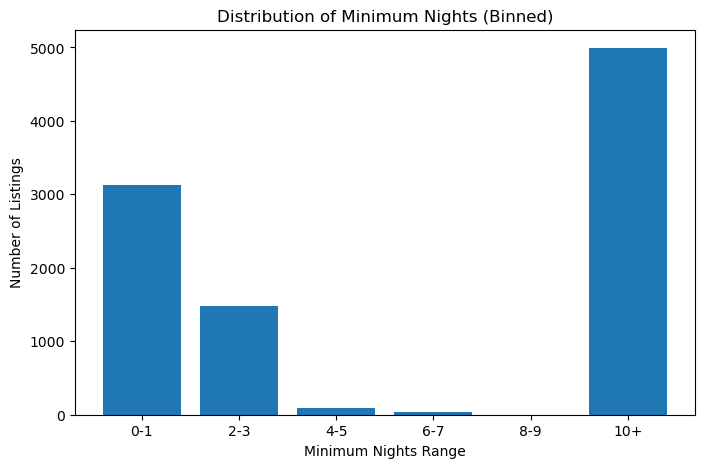

In [13]:
# Inconsistency 1: Minimum Nights are usually 10+ (counterintuitive). 
# After further exploration this is due to Montreal regulations (30 minimum night cap)
# Treatment on Minimum_Night variable in Outlier Section

# Define bins and labels
bins = [0, 1, 3, 5, 7, 9, float('inf')]
labels = ['0-1', '2-3', '4-5', '6-7', '8-9', '10+']

# Create binned variable
listings = listings.dropna(subset=['minimum_minimum_nights'])
listings['min_nights_bin'] = pd.cut(listings['minimum_minimum_nights'], bins=bins, labels=labels, right=True, include_lowest=True)

# Count per bin
min_night_counts = listings['min_nights_bin'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(min_night_counts.index, min_night_counts.values)
plt.title('Distribution of Minimum Nights (Binned)')
plt.xlabel('Minimum Nights Range')
plt.ylabel('Number of Listings')
plt.show()

In [14]:
# Inconsistency 2: Accents and weird characters leading to unstandardized entries. 
listings["neighbourhood_cleansed"].head(10)

0                              Ville-Marie
1                              Ville-Marie
2                    Le Plateau-Mont-Royal
3                              Ville-Marie
4                Rosemont-La Petite-Patrie
5                              Ville-Marie
6    CÃ´te-des-Neiges-Notre-Dame-de-GrÃ¢ce
7                              Ville-Marie
8                             Le Sud-Ouest
9                    Le Plateau-Mont-Royal
Name: neighbourhood_cleansed, dtype: object

### Action to Take on Inconsistencies

| Variables in table above (with inconsistencies)                      | Action                           | Inconsistency Treatment Plan |
|--------------------------------|----------------------------------|------------------------|
| minimum_nights                 | Convert to Binary (restricted vs not)       | Montreal regulations: treat ≥31 nights as “restricted” and others as “not restricted.” |
| $, %, Date | Standardize                        | Change to Number Type. |
| Accents | Mapping                        | Changing identified errors to a consistent format |


### Step 1b) Identified Outliers

In [15]:
# Outlier Detection via IQR Method
outlier_summary = []
for col in numeric_cols: 
    Min = listings[col].min()
    Max = listings[col].max()
    Q1 = listings[col].quantile(0.25)
    Q3 = listings[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = listings[(listings[col] < lower) | (listings[col] > upper)]
    outlier_summary.append({
        'Variable': col,
        'Min': Min,
        'Max': Max,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower,
        'Upper_Bound': upper,
        'Num_Outliers': len(outliers),
        'Pct_Outliers': round(len(outliers) / len(listings) * 100, 2)
    })

outlier_df = (
    pd.DataFrame(outlier_summary)
      .query("Pct_Outliers > 0")
      .sort_values(by="Pct_Outliers", ascending=False)
)

outlier_df

,Variable,Min,Max,Q1,Q3,IQR,Lower_Bound,Upper_Bound,Num_Outliers,Pct_Outliers
13,maximum_nights,1.00000,9.999900e+04,365.000000,365.00000,0.000000,365.000000,365.000000,4504,46.28
41,calculated_host_listings_count_private_rooms,0.00000,4.400000e+01,0.000000,0.00000,0.000000,0.000000,0.000000,2260,23.22
9,bathrooms,0.00000,1.600000e+01,1.000000,1.00000,0.000000,1.000000,1.000000,1747,17.95
40,calculated_host_listings_count_entire_homes,0.00000,1.390000e+02,1.000000,13.00000,12.000000,-17.000000,31.000000,1285,13.20
29,number_of_reviews_ly,0.00000,4.040000e+02,0.000000,13.00000,13.000000,-19.500000,32.500000,1268,13.03
39,calculated_host_listings_count,1.00000,1.390000e+02,1.000000,16.00000,15.000000,-21.500000,38.500000,1213,12.46
4,host_total_listings_count,1.00000,3.060000e+02,2.000000,29.00000,27.000000,-38.500000,69.500000,1173,12.05
25,number_of_reviews,0.00000,9.860000e+02,1.000000,46.00000,45.000000,-66.500000,113.500000,1056,10.85
3,host_listings_count,1.00000,1.850000e+02,2.000000,23.00000,21.000000,-29.500000,54.500000,1010,10.38
26,number_of_reviews_ltm,0.00000,3.760000e+02,0.000000,16.00000,16.000000,-24.000000,40.000000,951,9.77


### Action to take on Outliers:

| Variables in table above (with outliers)                      | Action                           | Outlier Treatment Plan |
|--------------------------------|----------------------------------|------------------------|
| maximum_nights                 | Cap at 365   | We don't want unrealistic numbers like 999 where the host probably mistyped |
| bedrooms                       | Remove   | Remove extreme outliers. These are hotels in Airbnb (40+ bedrooms). |
| accommodates                   | Remove   | Same as above. Remove extreme outliers. These are hotels in Airbnb |
| bathrooms                      | Remove   | Same as above. Remove extreme outliers. These are hotels in Airbnb. |
| beds                           | Remove   | Same as above. Remove extreme outliers. These are hotels in Airbnb consider dropping if redundant with accommodates. |
| calculated_host_listings_count | Cap at 90th percentile and bin   | Cap at the 90th-percentile; put larger values in one top bin to limit commercial operators’ leverage. |
| price                          | Log number                       | Model log(price) to handle skew. |
| number_of_reviews              | Binning                       | We bin into five unequally-spaced categories because after the last threshold we expect the marginal value of an incremental review is zero |
| minimum_nights                 | Convert to Binary (restricted vs not)       | Montreal regulations: treat **≥31 nights** as “restricted” and others as “not restricted.” |
| All other columns with outliers | Remove                        | Removed because they add no explanatory value to the model (metadata) or are duplicated elsewhere in the dataset definition. |


### Step 1c) Identified Duplicates

In [16]:
# Check for duplicate rows
duplicate_count = listings.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("Preview of duplicate rows:")
    display(listings_clean[listings.duplicated()].head())
else:
    print("No duplicate rows found in the dataset, so no further action needed")

Total number of duplicate rows: 0
No duplicate rows found in the dataset, so no further action needed


### Step 1d) Identified Missing Values

In [17]:
df = listings.copy()  # your dataframe

# Build summary
missing_value = pd.DataFrame({
    "Variable": df.columns,
    "Num_Missing": df.isna().sum().values
})
missing_value["Pct_Missing"] = (missing_value["Num_Missing"] / len(df) * 100).round(2)

# Sort and keep only columns with any missing values
missing_value = missing_value.sort_values("Pct_Missing", ascending=False).reset_index(drop=True)
missing_value_nonzero = missing_value[missing_value["Num_Missing"] > 0].reset_index(drop=True)

# Show
missing_value_nonzero

,Variable,Num_Missing,Pct_Missing
0,calendar_updated,9733,100.00
1,neighbourhood_group_cleansed,9733,100.00
2,host_neighbourhood,6402,65.78
3,neighborhood_overview,5444,55.93
4,neighbourhood,5444,55.93
5,host_about,4786,49.17
6,license,4481,46.04
7,host_location,2459,25.26
8,review_scores_accuracy,1849,19.00
9,review_scores_checkin,1849,19.00


### Action to take on Missing Values

| Variable                     | Amount |   %   | Action                                  | Our treatment plan explanation                                                                                                              |
| ---------------------------- | :----: | :---: | --------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| review_scores_accuracy       |  1849  | 18.99 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| review_scores_checkin        |  1849  | 18.99 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| review_scores_value          |  1849  | 18.99 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| review_scores_location       |  1849  | 18.99 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| review_scores_cleanliness    |  1849  | 18.99 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| review_scores_communication  |  1849  | 18.99 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| last_review                  |  1848  | 18.98 | Remove column                        | Just a date                                                                                               |
| review_scores_rating         |  1848  | 18.98 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| first_review                 |  1848  | 18.98 | Remove Column                        | Just a date                                                                                               |
| reviews_per_month            |  1848  | 18.98 | Input 0 in empty                        | Empty in the dataset means no rating yet                                                                                               |
| host_response_time           |  1006  | 10.33 | No action                            | Lack of data is understandable. Means host is new                            |
| host_response_rate           |  1006  | 10.33 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| bathrooms                    |   963  |  9.89 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| beds                         |   962  |  9.88 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| host_acceptance_rate         |   866  |  8.89 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| bedrooms                     |   178  |  1.83 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| host_is_superhost            |   452  |  4.64 | Use median or K-NN with the criteria as per Airbnb | Airbnb has criteria that defines superhost. We will use median or K-NN to impute this field                                                 |
| price                        |   959  |  9.85 | Remove rows                             | Because price is the dependent variable, imputing it would leak information and distort the loss; exclude for training/validation |
| calendar_updated             |  9737  |  100  | Remove Column                           | Metadata or already in other column                                                                                               |
| neighbourhood_group_cleansed |  9737  |  100  | Remove Column                           | Metadata or already in other column                                                                                               |
| host_neighbourhood           |  6406  | 65.79 | Remove Column                           | Metadata or already in other column                                                                                               |
| neighborhood_overview        |  5447  | 55.94 | Remove Column                           | Metadata or already in other column                                                                                               |
| neighbourhood                |  5447  | 55.94 | Remove Column                           | Metadata or already in other column                                                                                               |
| host_about                   |  4786  | 49.15 | Remove Column                           | Metadata or already in other column                                                                                               |
| license                      |  4481  | 46.02 | Remove Column                           | Metadata or already in other column                                                                                               |
| host_location                |  2459  | 25.25 | Remove Column                           | Metadata or already in other column                                                                                               |
| estimated_revenue_l365d      |   959  |  9.85 | Remove Column                           | Metadata or already in other column                                                                                               |
| description                  |   160  |  1.64 | Remove Column                           | Metadata or already in other column                                                                                               |
| has_availability             |   121  |  1.24 | Remove Column                           | Metadata or already in other column                                                                                               |
| bathrooms_text               |    6   |  0.06 | Remove Column                           | Metadata or already in other column                                                                                               |
| minimum_maximum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| min_nights_bin               |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| maximum_maximum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| minimum_minimum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| maximum_minimum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                                                                                             


## Step 2. Addressing the Inconsistencies, Duplicates and Standardizing Analysis


In [18]:
#Creating new data frame to start addressing datatypes for analysis
listings_clean = listings

### Step 2a) Addressing Inconsistencies

1. Converting non conventional data like price, date and % format to number
2. We cap minimum_nights at 31 because very high values usually reflect regulatory or platform constraints (e.g., hosts setting 30+ days to meet local rules) rather than true host/guest preferences. Those administrative limits add noise unrelated to price or demand and can skew model fits. We keep the original column, add a capped feature, and flag affected rows so it’s transparent.


In [19]:
#Checking for inconsistencies in the categorical columns

# Set a threshold for what's considered "categorical"
# (vs. free text like 'description')
UNIQUE_VALUE_THRESHOLD = 50 

# Select all 'object' type columns
object_cols = listings_clean.select_dtypes(include=['object'])

print("--- Checking Low-Cardinality 'object' Columns ---")

for col in object_cols.columns:
    
    unique_count = listings_clean[col].nunique()
    
    if unique_count > UNIQUE_VALUE_THRESHOLD:
        print(f"\n[SKIPPING] '{col}': Too many unique values ({unique_count}). Likely free text.")
        continue
        
    print(f"\n--- Column: {col} ({unique_count} unique values) ---")
    
    # Print all unique values
    # .index gets just the category names, not the counts
    print(listings_clean[col].value_counts().index.tolist())

--- Checking Low-Cardinality 'object' Columns ---

[SKIPPING] 'listing_url': Too many unique values (9733). Likely free text.

--- Column: last_scraped (3 unique values) ---
['6/26/25', '6/27/25', '6/25/25']

--- Column: source (2 unique values) ---
['city scrape', 'previous scrape']

[SKIPPING] 'name': Too many unique values (9377). Likely free text.

[SKIPPING] 'description': Too many unique values (7522). Likely free text.

[SKIPPING] 'neighborhood_overview': Too many unique values (2748). Likely free text.

[SKIPPING] 'picture_url': Too many unique values (9513). Likely free text.

[SKIPPING] 'host_url': Too many unique values (3839). Likely free text.

[SKIPPING] 'host_name': Too many unique values (2227). Likely free text.

[SKIPPING] 'host_location': Too many unique values (162). Likely free text.

[SKIPPING] 'host_about': Too many unique values (1760). Likely free text.

--- Column: host_response_time (4 unique values) ---
['within an hour', 'within a few hours', 'within a day'

In [20]:
# Converting to Numeric - removing $ and % signs
clean_host_response_rate = listings_clean.host_response_rate.str.replace('%','').str.replace(',','')
listings_clean['host_response_rate']=clean_host_response_rate

clean_host_acceptance_rate = listings_clean.host_acceptance_rate.str.replace('%','').str.replace(',','')
listings_clean['host_acceptance_rate']=clean_host_acceptance_rate

clean_price = listings_clean.price.str.replace('$','').str.replace(',','').astype(float)
listings_clean['price']=clean_price


# Creating a regulated vs not regulated column to address Montreal Min night regulations: If listing is allowed to book for <31 nights its "not regulated", else its "regulated"
listings_clean["min_nights_regulation"] = np.where(
    listings_clean["minimum_nights"] < 31, "not regulated", "regulated"
)

# Dictionary mapping corrupted names to corrected ones
fix_map = {
    "CÃ´te-des-Neiges-Notre-Dame-de-GrÃ¢ce": "Cote-des-Neiges–Notre-Dame-de-Grace",
    "Baie-d'UrfÃ©": "Baie-d’Urfe",
    "RiviÃ¨re-des-Prairies-Pointe-aux-Trembles": "Riviere-des-Prairies–Pointe-aux-Trembles",
    "CÃ´te-Saint-Luc": "Cote-Saint-Luc",
    "L'ÃŽle-Bizard-Sainte-GeneviÃ¨ve": "L’Ile-Bizard–Sainte-Genevieve",
    "Saint-LÃ©onard": "Saint-Leonard",
    "MontrÃ©al-Ouest": "Montreal-Ouest",
    "MontrÃ©al-Nord": "Montreal-Nord",
    "MontrÃ©al-Est": "Montreal-Est"
}

# Apply replacements
listings_clean["neighbourhood_cleansed"] = (
    listings_clean["neighbourhood_cleansed"].replace(fix_map)
)
listings_clean["neighbourhood_cleansed"].unique()


array(['Ville-Marie', 'Le Plateau-Mont-Royal',
       'Rosemont-La Petite-Patrie', 'Cote-des-Neiges–Notre-Dame-de-Grace',
       'Le Sud-Ouest', 'Villeray-Saint-Michel-Parc-Extension',
       'Baie-d’Urfe', 'Mercier-Hochelaga-Maisonneuve', 'Saint-Laurent',
       'Lachine', 'Ahuntsic-Cartierville', 'Outremont', 'Westmount',
       'Riviere-des-Prairies–Pointe-aux-Trembles', 'Anjou',
       'Pointe-Claire', 'Mont-Royal', 'Verdun', 'LaSalle',
       'Cote-Saint-Luc', 'Hampstead', 'L’Ile-Bizard–Sainte-Genevieve',
       'Saint-Leonard', 'Dollard-des-Ormeaux', 'Dorval',
       'Pierrefonds-Roxboro', 'Montreal-Ouest', 'Beaconsfield',
       'Montreal-Nord', 'Kirkland', 'Montreal-Est',
       'Sainte-Anne-de-Bellevue'], dtype=object)

### Step 2b) Addressing Outliers

1. Capping maximum nights available to rent to 90. Per the definition in Quebec, anyone renting for less than 90 days is defined as short term rentee
2. Dropped any features beyond 3 standard deviations for bedrooms, bathrooms, acommodates and beds.
3. Dropped any rows where the hosts had more listings than 99.7 percentile (3std). By looking at the data, these represented hotels and may distort the model from its purpose.
4. Logged price and number of reviews to prevent bias.


In [21]:
# Max nights capped at 365 to remove unrealistic values

listings_clean['maximum_nights'] = listings['maximum_nights'].clip(upper=365)

## sanity check: listings_clean[["maximum_nights","maximum_nights_capped","maximum_nights_bin"]].head(40)

################################################################################################################################
#################################################################################################################################

# Min nights Create a regulation flag
listings_clean['regulated'] = np.where(listings_clean['minimum_nights'] < 31, 0, 1)

################################################################################################################################
#################################################################################################################################

# Beds/Accomodates/Bathrooms outlier handling:
#Finding extreme outliers (hotels). Anything at 3 std  will be removed.

house_features_to_check = ["bedrooms", "bathrooms", "accommodates", "beds"]
# Get averages and spreads
averages = listings[house_features_to_check].mean()
spreads  = listings[house_features_to_check].std()

# Cap values above +3 std or below -3 std
for feature in house_features_to_check:
    lower = averages[feature] - 3 * spreads[feature]
    upper = averages[feature] + 3 * spreads[feature]
    listings_clean[feature] = listings_clean[feature].clip(lower=0, upper=upper) # Im setting lower = 0 cause we cant have negative bathrooms


#################################################################################################################################
#################################################################################################################################
# Host Listing outlier handling. Capping any host who has an insane amount of listings to the 99.7 percentile
p99_chlc = listings["calculated_host_listings_count"].quantile(0.997)
listings_clean["calculated_host_listings_count"] = (
    listings["calculated_host_listings_count"].clip(upper=p99_chlc)
)

#################################################################################################################################
#################################################################################################################################
# price and number of reviews outlier handling. Log the values to avoid heavy weight to anomalies. Creating new columns rather than rewriting just in case

listings_clean["price_log"] = np.where(listings_clean["price"] > 0,
                                       np.log(listings_clean["price"]), np.nan)
listings_clean["number_of_reviews_log"] = np.log1p(listings_clean["number_of_reviews"])

### Step 2c) Addressing Missing Data

1. Missing reviews means the airbnb has not been booked. To avoid lack of bookings in new airbnb to swaying data one way or another we will input the media.
2. Removing any data without price.

In [22]:
###############################################################################################################################################
###############################################################################################################################################
#Adressing Missing Values in host_response_time

#This feature is categorical and the data is ordinal, so it would be best to map to an hour scale and then impute the median

# Mapping dictionary
response_map = {
    'within an hour': 1,
    'within a few hours': 3,
    'within a day': 24,
    'a few days or more': 72
}

# Map and overwrite the original column in place
listings_clean['host_response_time'] = listings_clean['host_response_time'].map(response_map)


###############################################################################################################################################
###############################################################################################################################################

# Columns where we'll fill missing values with the median
cols_to_fill_with_median = [
  "host_response_rate", "bathrooms",
    "beds", "host_acceptance_rate", "bedrooms", "review_scores_accuracy", "review_scores_checkin", "review_scores_value",
    "review_scores_location", "review_scores_cleanliness",
    "review_scores_communication",
    "review_scores_rating", "reviews_per_month","host_response_time"
]

# Fill missing values using each column's median
for col in cols_to_fill_with_median:
    listings_clean[col] = pd.to_numeric(listings_clean[col], errors="coerce")
    median_value = listings_clean[col].median()
    listings_clean[col] = listings_clean[col].fillna(median_value)

###############################################################################################################################################
###############################################################################################################################################
# Dropping any value without prices to avoid distorting prediction

listings_clean = listings_clean.dropna(subset=["price"]).copy()

###############################################################################################################################################
###############################################################################################################################################
#Address missing values in 'host_is_superhost'

# 1. Fill NaNs based on other listings from the same host
# Groups by 'host_id' and takes the first non-null value
# (e.g., 't', 'f') and broadcasts it to all rows for that host.
# If a host only has NaN values, they will remain NaN.
listings_clean['host_is_superhost'] = listings_clean.groupby('host_id')['host_is_superhost'].transform('first')

print(f"Missing values after grouping: {listings_clean['host_is_superhost'].isna().sum()}")

# 2. Fill any remaining NaNs
# If a host had NaN for *all* their listings, we must make a default assumption.
# The safest assumption is that if the status is unknown, they are 'f' (false),
# as Superhost is an earned status.
listings_clean['host_is_superhost'] = listings_clean['host_is_superhost'].fillna('f')

print(f"Missing values after final fill: {listings_clean['host_is_superhost'].isna().sum()}")

# Check the result
print(listings_clean['host_is_superhost'].value_counts())



print("Remaining rows:", len(listings_clean))

Missing values after grouping: 427
Missing values after final fill: 0
host_is_superhost
f    5468
t    3306
Name: count, dtype: int64
Remaining rows: 8774


### Final Step Before Variable Selection: Remove Metadata or Redundant Categories

In [23]:
# Columns to drop
drop_in_listings_clean = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description',
    'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name',
    'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
    'host_neighbourhood', 'host_total_listings_count', 'host_verifications',
    'neighbourhood', 'neighbourhood_group_cleansed',
    'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60',
    'availability_90', 'calendar_last_scraped',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy',
    'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d',
    'first_review', 'license',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'has_availability'
]

# Drop them from the DataFrame (ignore missing just in case)
listings_clean = listings_clean.drop(columns=drop_in_listings_clean, errors='ignore')

cols_list = listings_clean.columns


# Check remaining columns
print("Remaining columns:", listings_clean.columns.tolist())
print(f"There are {len(listings_clean.columns)} columns remaining.")

Remaining columns: ['host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'min_nights_bin', 'min_nights_regulation', 'regulated', 'price_log', 'number_of_reviews_log']
There are 38 columns remaining.


#### Confirming Missing Data Handling

In [24]:
df = listings_clean.copy()  # your dataframe

# Build summary
missing_value = pd.DataFrame({
    "Variable": df.columns,
    "Num_Missing": df.isna().sum().values
})
missing_value["Pct_Missing"] = (missing_value["Num_Missing"] / len(df) * 100).round(2)

# Sort and keep only columns with any missing values
missing_value = missing_value.sort_values("Pct_Missing", ascending=False).reset_index(drop=True)
missing_value_nonzero = missing_value[missing_value["Num_Missing"] > 0].reset_index(drop=True)

if missing_value_nonzero.empty:
    print("No missing data found.")
else:
    print("Found missing data:")
    display(missing_value_nonzero)

Found missing data:


,Variable,Num_Missing,Pct_Missing
0,last_review,1604,18.28


In [25]:
# Check how many 'number_of_reviews' are 0
print(f"Listings with 0 reviews: {(df['number_of_reviews'] == 0).sum()}")
# Check how many 'last_review' are missing
print(f"Missing 'last_review' values: {df['last_review'].isna().sum()}")

#We can see that the number of listings with 0 reviews matches the number of missing 'last_review' entries.

#Later, we will create a days_since_last_review feature to address this and impute with larger numbers for listings with 0 reviews.

Listings with 0 reviews: 1604
Missing 'last_review' values: 1604


# Exploratory Data Analysis (EDA)

## Exploring Target Variable
- Visualize the right-skewed pricing target variable and the change to a more normal distribution after log transformation

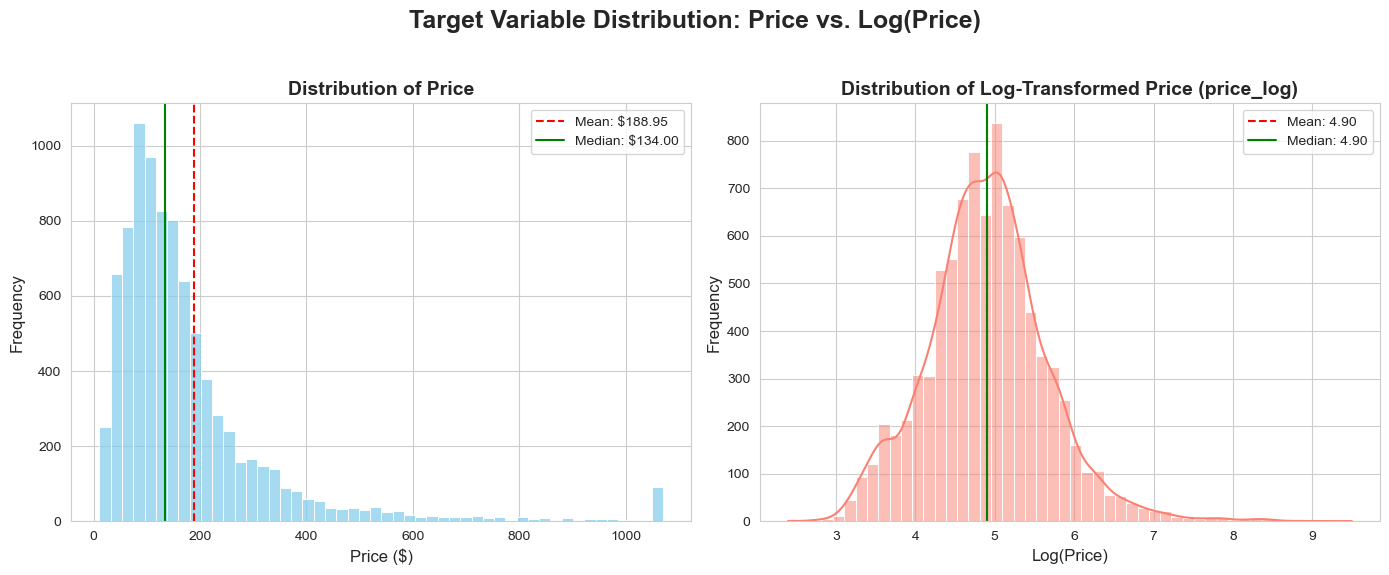

In [26]:
# Set the figure size for better readability
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Histogram for "price"
#Clipping outliers at 99th percentile for better visualization
ax1 = plt.subplot(1, 2, 1)
price_99th = listings_clean['price'].quantile(0.99)

sns.histplot(listings_clean['price'].clip(0, price_99th), bins=50, kde=False, ax=ax1, color='skyblue')
ax1.set_title('Distribution of Price', fontsize=14, fontweight='bold')
ax1.set_xlabel('Price ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(listings_clean['price'].mean(), color='red', linestyle='--', label=f"Mean: ${listings_clean['price'].mean():.2f}")
ax1.axvline(listings_clean['price'].median(), color='green', linestyle='-', label=f"Median: ${listings_clean['price'].median():.2f}")
ax1.legend()


# Histogram for Log-Transformed Price 
ax2 = plt.subplot(1, 2, 2)
sns.histplot(listings_clean['price_log'], bins=50, kde=True, ax=ax2, color='salmon')
ax2.set_title('Distribution of Log-Transformed Price (price_log)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Log(Price)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.axvline(listings_clean['price_log'].mean(), color='red', linestyle='--', label=f"Mean: {listings_clean['price_log'].mean():.2f}")
ax2.axvline(listings_clean['price_log'].median(), color='green', linestyle='-', label=f"Median: {listings_clean['price_log'].median():.2f}")
ax2.legend()


# --- Final Touches ---
plt.suptitle('Target Variable Distribution: Price vs. Log(Price)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Spatial Analysis of Montreal Neighbourhoods

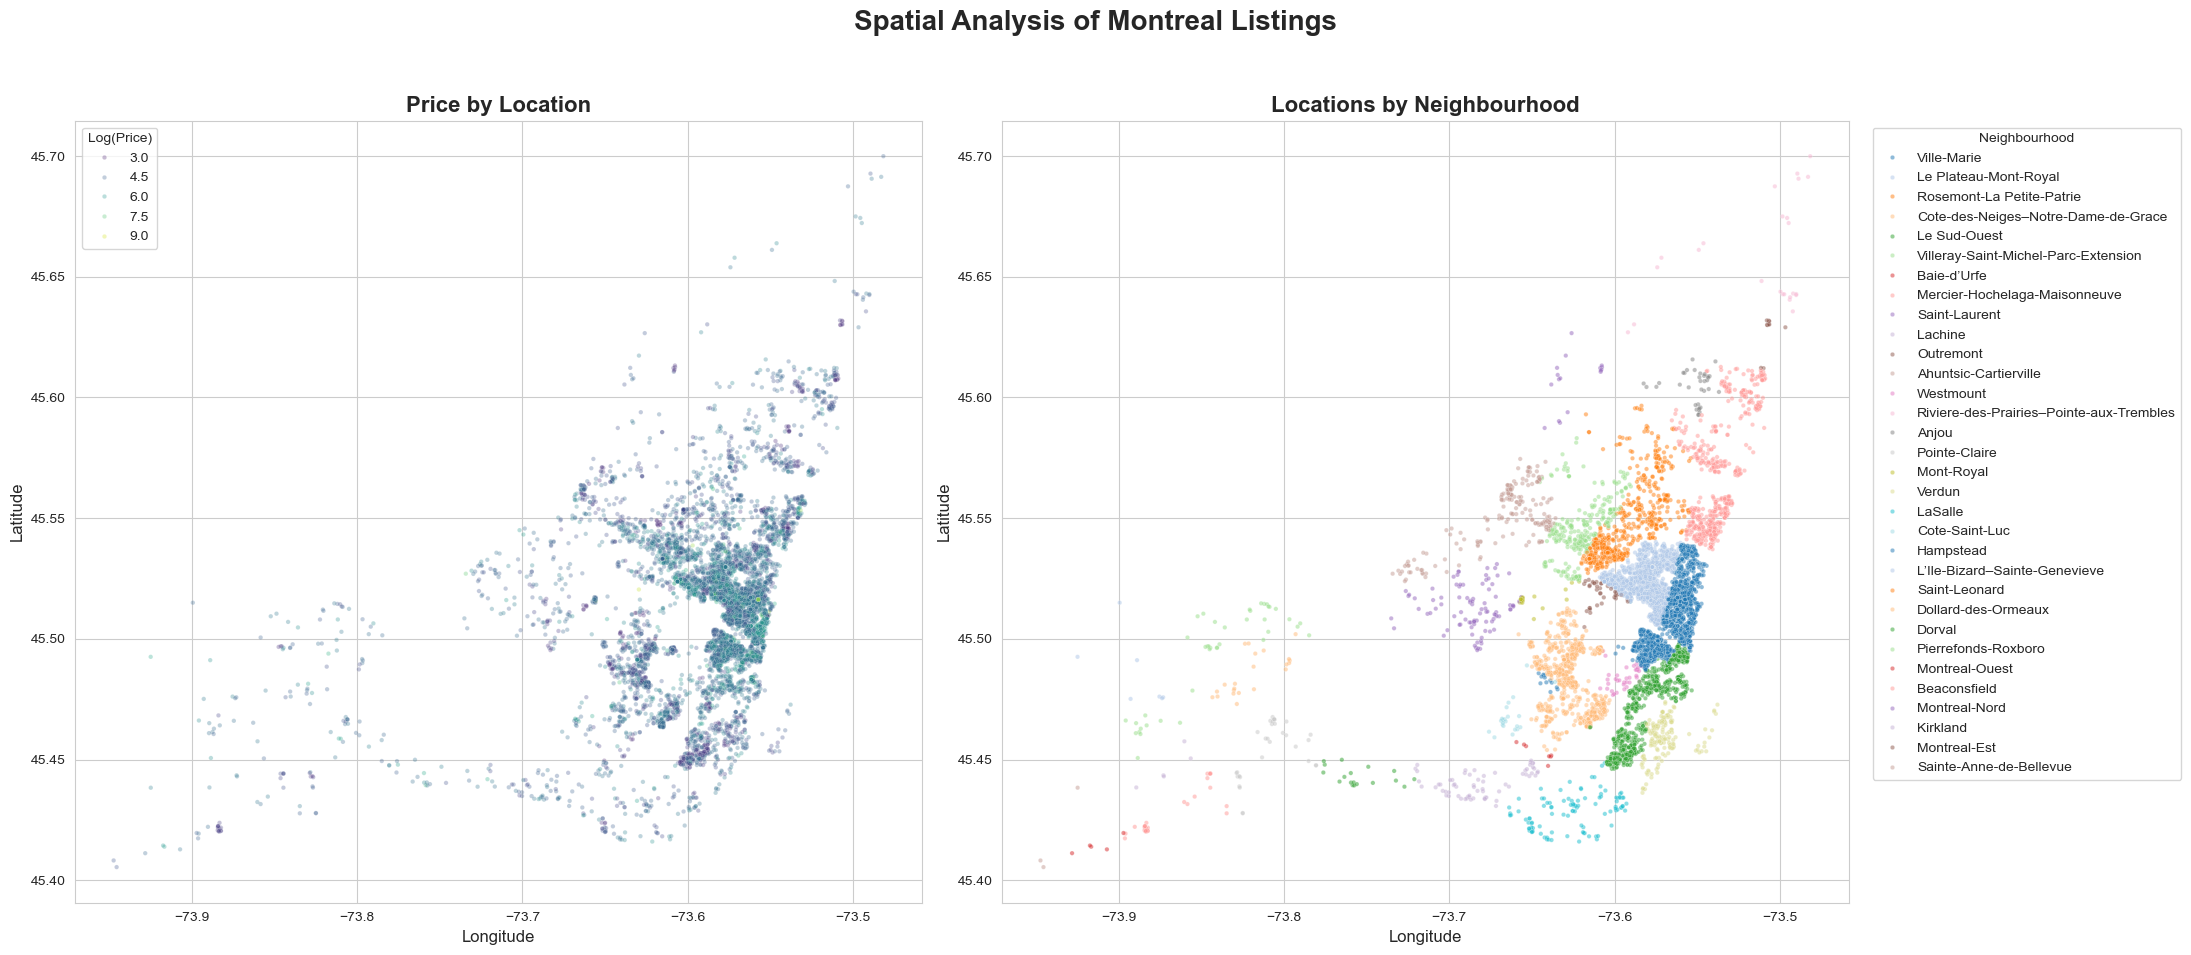

In [27]:
#Creating side by side scatter plots for spatial analysis of Montreal listings

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle('Spatial Analysis of Montreal Listings', fontsize=20, fontweight='bold')


# --- 2. Plot 1: Colored by Price (price_log) ---
sns.scatterplot(
    data=listings_clean,
    x='longitude',
    y='latitude',
    hue='price_log',           # Color points based on log-price
    palette='viridis',         # A good color map for continuous data (dark-to-bright)
    alpha=0.3,                 # Transparency to show density
    s=10,                      # Smaller point size
    ax=ax1                     # Plot on the first axis
)
ax1.set_title('Price by Location', fontsize=16, fontweight='bold')
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.legend(title='Log(Price)')
ax1.grid(True) # Add grid for reference


# --- 3. Plot 2: Colored by Neighbourhood ---
sns.scatterplot(
    data=listings_clean,
    x='longitude',
    y='latitude',
    hue='neighbourhood_cleansed', # Color points based on neighborhood
    palette='tab20',             # A palette with many distinct colors
    alpha=0.5,
    s=10,
    legend='full',               # Show the full legend
    ax=ax2                       # Plot on the second axis
)
ax2.set_title('Locations by Neighbourhood', fontsize=16, fontweight='bold')
ax2.set_xlabel('Longitude', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)

# Move the legend outside the plot so it doesn't cover the data
ax2.legend(title='Neighbourhood', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.grid(True) # Add grid for reference


# --- 4. Show the Plots ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

#### Interpretation
The listing price is clearly correlated with geographic locations. We see a dense central cluster of high-price listings, corresponding to "Ville-Marie" and "Le Plateau-Mont-Royal" neighbourhoods. As listings move to more peripheral neighbourhopods, we see the prices drop significantly. This visual supports using neighbourhood_cleansed as a key predictive feature for pricing prediction. 

In [28]:
#Depending on whether we use these columns in the model later on, can drop
listings_clean = listings_clean.drop(columns=['latitude', 'longitude'])

## Identifying Explanatory Variables

Initially, we selected the following variables because they represent listing-level attributes that may influence price or reflect host behavior and listing quality.  
We excluded metadata, IDs, URLs, text descriptions, and redundant geographic details.



| **#** | **Variable Name** |
|:----:|:------------------------------|
| 1 | host_since |
| 2 | host_response_time |
| 3 | host_response_rate |
| 4 | host_acceptance_rate |
| 5 | host_is_superhost |
| 6 | host_listings_count |
| 7 | host_has_profile_pic |
| 8 | host_identity_verified |
| 9 | neighbourhood_cleansed |
| 10 | property_type |
| 11 | room_type |
| 12 | accommodates |
| 13 | bathrooms |
| 14 | bedrooms |
| 15 | beds |
| 16 | amenities |
| 17 | price |
| 18 | minimum_nights |
| 19 | maximum_nights |
| 20 | has_availability |
| 21 | availability_365 |
| 22 | number_of_reviews |
| 23 | review_scores_rating |
| 24 | review_scores_accuracy |
| 25 | review_scores_cleanliness |
| 26 | review_scores_checkin |
| 27 | review_scores_communication |
| 28 | review_scores_location |
| 29 | review_scores_value |
| 30 | instant_bookable |
| 31 | calculated_host_listings_count |


## Variable exploration on Numeric columns

In [29]:
# Keep only numeric columns
numeric_cols = listings_clean.select_dtypes(include=[np.number]).columns

# Calculate correlations
corr = listings_clean[numeric_cols].corr()

# Show the correlation of each variable with log_price
corr_with_price = corr['price_log'].sort_values(ascending=False)
print(corr_with_price)


# Find pairs of variables that are highly correlated with each other
high_corr = corr[(corr > 0.8) & (corr < 1.0)]
print("Highly correlated pairs (above 0.8):")
print(high_corr.dropna(how='all').dropna(axis=1, how='all'))


price_log                         1.000000
price                             0.651002
accommodates                      0.616037
beds                              0.519694
bedrooms                          0.501040
bathrooms                         0.340930
number_of_reviews_log             0.215431
host_acceptance_rate              0.186534
number_of_reviews                 0.168550
review_scores_cleanliness         0.150324
review_scores_location            0.143065
review_scores_rating              0.124375
review_scores_value               0.118962
host_response_rate                0.109690
review_scores_accuracy            0.093605
review_scores_communication       0.089406
review_scores_checkin             0.070314
availability_365                 -0.003000
maximum_nights                   -0.006526
calculated_host_listings_count   -0.019540
host_listings_count              -0.019872
host_response_time               -0.107854
minimum_nights                   -0.219327
regulated  

In [30]:
#Performs a bivariate correlation analysis between 'price_log' and all other numeric variables in the listings_clean DataFrame using Pearson's correlation coefficient.

# The final list of numerical features to check correlation against 'price_log'
features_to_check = [col for col in numeric_cols if col not in ['price', 'price_log']]

for col in features_to_check:
    # Select the two columns and drop any rows with missing values
    temp = listings_clean[['price_log', col]].dropna()

    # Force 1-D arrays for correlation function
    x = temp['price_log'].to_numpy().ravel()
    y = temp[col].to_numpy().ravel()

    # Calculate Pearson's r and p-value
    r, p_val = stats.pearsonr(x, y)

    # Ensure scalars for f-string formatting
    r = float(np.squeeze(r))
    p_val = float(np.squeeze(p_val))

    # Print results
    print(f"{col:35} | r = {r:6.3f} | p-value = {p_val:8.5f}")

host_response_time                  | r = -0.108 | p-value =  0.00000
host_response_rate                  | r =  0.110 | p-value =  0.00000
host_acceptance_rate                | r =  0.187 | p-value =  0.00000
host_listings_count                 | r = -0.020 | p-value =  0.06270
accommodates                        | r =  0.616 | p-value =  0.00000
bathrooms                           | r =  0.341 | p-value =  0.00000
bedrooms                            | r =  0.501 | p-value =  0.00000
beds                                | r =  0.520 | p-value =  0.00000
minimum_nights                      | r = -0.219 | p-value =  0.00000
maximum_nights                      | r = -0.007 | p-value =  0.54109
availability_365                    | r = -0.003 | p-value =  0.77872
number_of_reviews                   | r =  0.169 | p-value =  0.00000
review_scores_rating                | r =  0.124 | p-value =  0.00000
review_scores_accuracy              | r =  0.094 | p-value =  0.00000
review_scores_cleanl

Numerical features most associated with price are accommodates, beds, bedrooms, and bathrooms, showing clear positive relationships.
Minimum nights stands out with a negative relationship — longer stay requirements generally lower the nightly rate.
Review scores and host metrics (like response rate or acceptance rate) show weaker correlations, meaning they only play a minor role in price determination. 

Next, we will visualize the relationships between accomodates, beds, bedrooms, bathrooms and min_nights versus price_log as scatter plots.

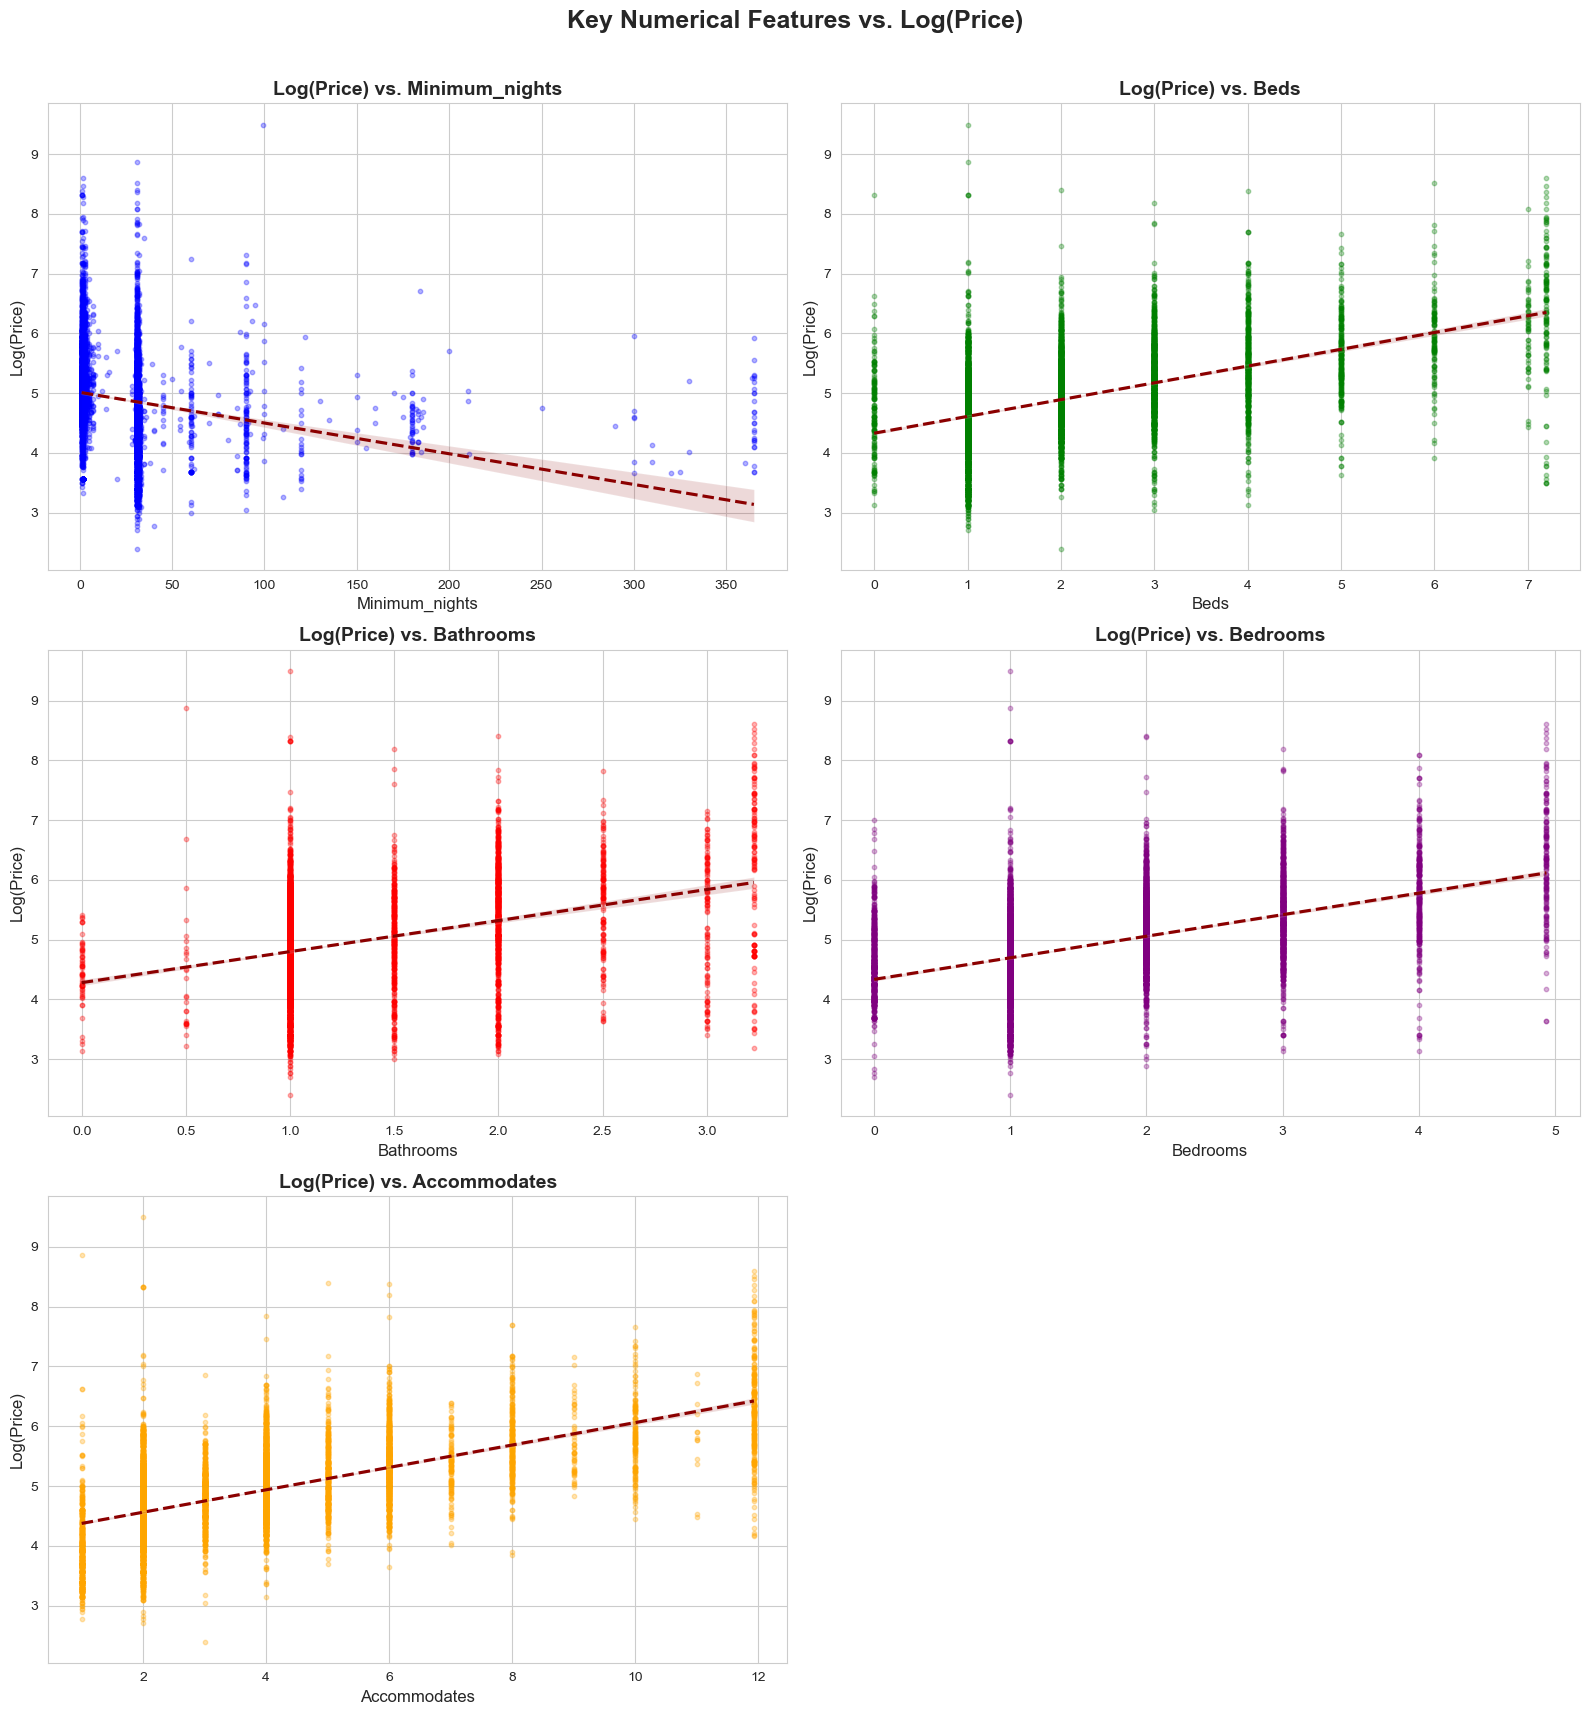

In [31]:
#Create scatter plots with regression lines for the most highly correlated numerical features against log-transformed price
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

# Define Features to Plot ---
features_to_plot = ['minimum_nights', 'beds', 'bathrooms', 'bedrooms', 'accommodates']
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Key Numerical Features vs. Log(Price)', fontsize=18, fontweight='bold')

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Loop and Plot
for i, feature in enumerate(features_to_plot):
    ax = axes_flat[i]
    
    # Check if the feature exists in the DataFrame to avoid KeyErrors
    if feature in listings_clean.columns:
        # Use regplot for scatter + regression line
        # Use scatter_kws to make points semi-transparent for readability
        sns.regplot(
            data=listings_clean,
            x=feature,
            y='price_log',
            ax=ax,
            color=colors[i],
            scatter_kws={'alpha': 0.3, 's': 10}, # s = point size
            line_kws={'color': 'darkred', 'linestyle': '--'}
        )
        
        ax.set_title(f'Log(Price) vs. {feature.capitalize()}', fontsize=14, fontweight='bold')
        ax.set_xlabel(feature.capitalize(), fontsize=12)
        ax.set_ylabel('Log(Price)', fontsize=12)
        
    else:
        # Handle case where a column might be missing
        ax.set_title(f"Column '{feature}' not found", fontsize=14, fontweight='bold')
        ax.text(0.5, 0.5, f"'{feature}' not in DataFrame", 
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=ax.transAxes, 
                color='red')

# Clean up and Show
 # Turn off the last unused subplot
if len(features_to_plot) < len(axes_flat):
    axes_flat[-1].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## Exploration on Categorical Variables


--- host_is_superhost ---
host_is_superhost
t    5.027982
f    4.825982
Name: price_log, dtype: float64


<Figure size 600x400 with 0 Axes>

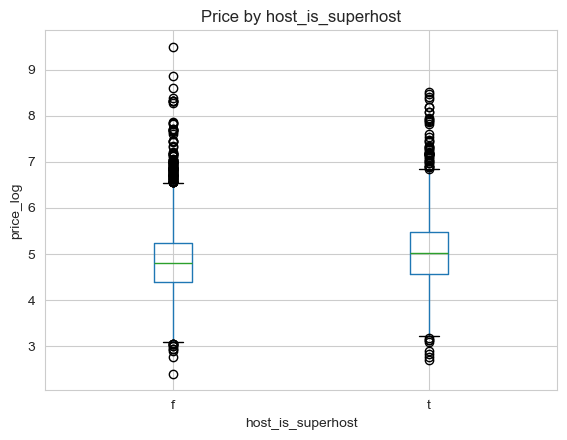


--- host_has_profile_pic ---
host_has_profile_pic
t    4.906476
f    4.719869
Name: price_log, dtype: float64


<Figure size 600x400 with 0 Axes>

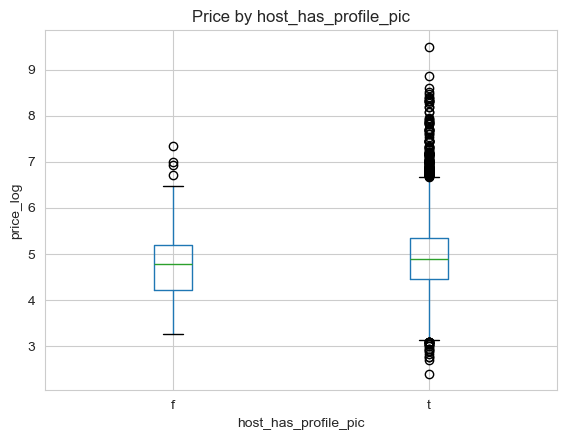


--- host_identity_verified ---
host_identity_verified
t    4.903126
f    4.883712
Name: price_log, dtype: float64


<Figure size 600x400 with 0 Axes>

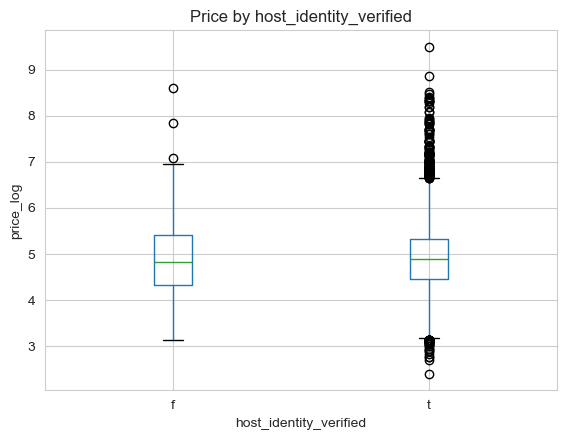


--- neighbourhood_cleansed ---
neighbourhood_cleansed
L’Ile-Bizard–Sainte-Genevieve               5.288456
Dorval                                      5.262218
Baie-d’Urfe                                 5.258608
Outremont                                   5.146985
Le Plateau-Mont-Royal                       5.130019
Mont-Royal                                  5.102358
Ville-Marie                                 5.088146
Westmount                                   5.010111
Cote-Saint-Luc                              5.004949
Kirkland                                    4.966768
Hampstead                                   4.861290
Rosemont-La Petite-Patrie                   4.835577
Dollard-des-Ormeaux                         4.823804
Le Sud-Ouest                                4.804772
Pierrefonds-Roxboro                         4.774437
Riviere-des-Prairies–Pointe-aux-Trembles    4.751357
Pointe-Claire                               4.656185
Anjou                                       

<Figure size 600x400 with 0 Axes>

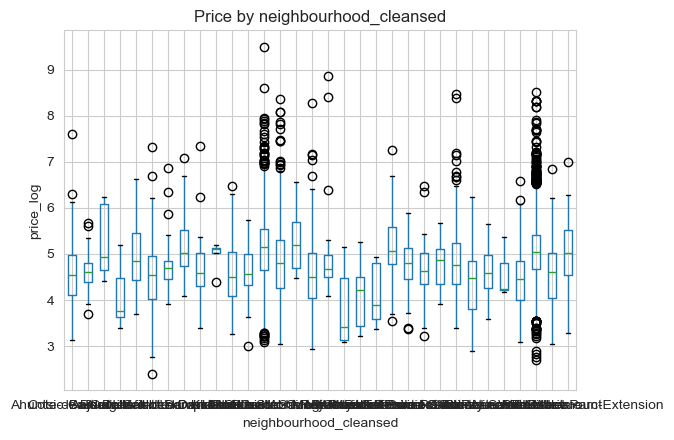


--- property_type ---
property_type
Entire chalet                         6.569481
Entire villa                          6.087653
Castle                                6.057858
Entire vacation home                  5.848764
Room in aparthotel                    5.645163
Entire townhouse                      5.622947
Entire cottage                        5.615264
Entire home                           5.471343
Entire loft                           5.181923
Room in boutique hotel                5.163585
Entire bungalow                       5.161537
Entire serviced apartment             5.155105
Entire condo                          5.060864
Entire rental unit                    5.001185
Entire place                          4.975186
Room in hotel                         4.962971
Private room in hostel                4.876918
Private room in bed and breakfast     4.875200
Religious building                    4.636262
Entire guest suite                    4.627409
Entire cabin           

<Figure size 600x400 with 0 Axes>

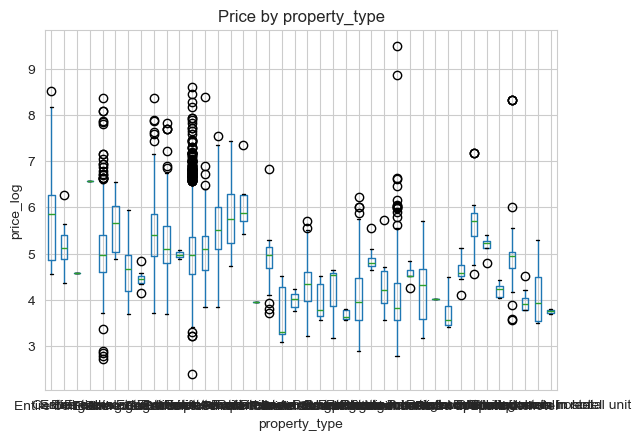


--- room_type ---
room_type
Hotel room         5.440441
Entire home/apt    5.052877
Private room       4.146885
Shared room        4.036666
Name: price_log, dtype: float64


<Figure size 600x400 with 0 Axes>

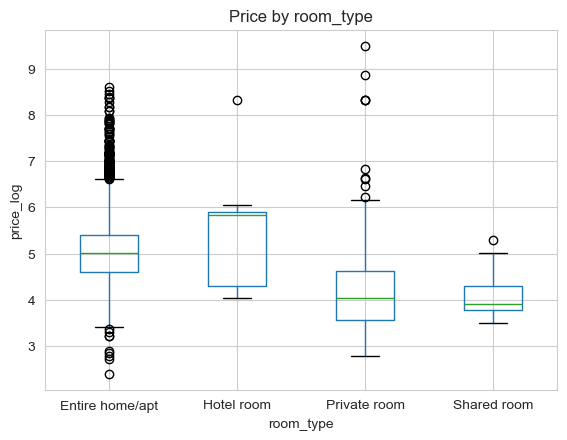


--- instant_bookable ---
instant_bookable
t    5.021795
f    4.824454
Name: price_log, dtype: float64


<Figure size 600x400 with 0 Axes>

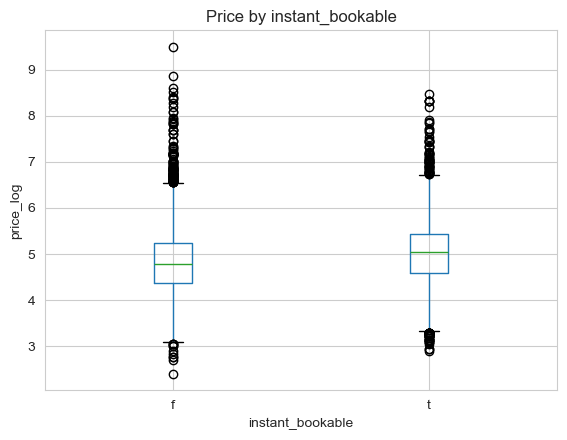


--- min_nights_bin ---
min_nights_bin
2-3    5.242530
0-1    5.207764
4-5    5.123481
6-7    5.011831
10+    4.566324
8-9         NaN
Name: price_log, dtype: float64


<Figure size 600x400 with 0 Axes>

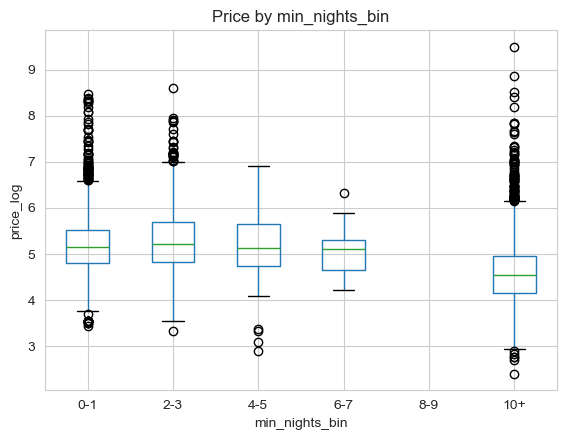


--- min_nights_regulation ---
min_nights_regulation
not regulated    5.192865
regulated        4.655087
Name: price_log, dtype: float64


<Figure size 600x400 with 0 Axes>

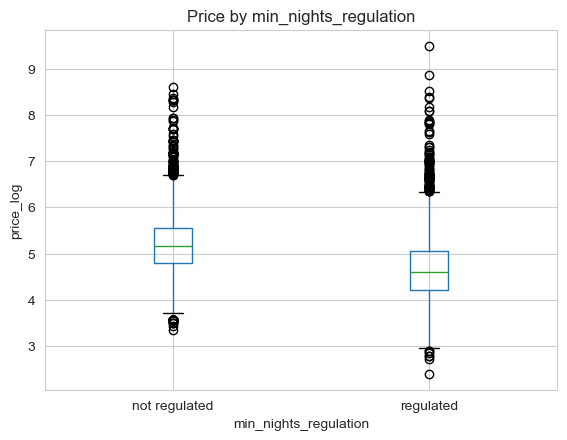

In [32]:
#Creating boxplots with log_price versus each categorical variable to see if there are differences in price across categories.

# Identify categorical columns
categorical_cols = listings_clean.select_dtypes(include=['object', 'category']).columns

# Loop through each categorical variable
for col in categorical_cols:
    if listings_clean[col].nunique() < 100:  # skip those with too many categories (e.g. neighbourhood)
        print(f"\n--- {col} ---")
        
# Group by the category and calculate average log_price
        avg_price = listings_clean.groupby(col)['price_log'].mean().sort_values(ascending=False)
        print(avg_price)
# visual check
        plt.figure(figsize=(6,4))
        listings_clean.boxplot(column='price_log', by=col)
        plt.title(f'Price by {col}')
        plt.suptitle('')
        plt.xlabel(col)
        plt.ylabel('price_log')
        plt.show()


neighbourhood_cleansed
L’Ile-Bizard–Sainte-Genevieve               5.288456
Dorval                                      5.262218
Baie-d’Urfe                                 5.258608
Outremont                                   5.146985
Le Plateau-Mont-Royal                       5.130019
Mont-Royal                                  5.102358
Ville-Marie                                 5.088146
Westmount                                   5.010111
Cote-Saint-Luc                              5.004949
Kirkland                                    4.966768
Hampstead                                   4.861290
Rosemont-La Petite-Patrie                   4.835577
Dollard-des-Ormeaux                         4.823804
Le Sud-Ouest                                4.804772
Pierrefonds-Roxboro                         4.774437
Riviere-des-Prairies–Pointe-aux-Trembles    4.751357
Pointe-Claire                               4.656185
Anjou                                       4.626138
Sainte-Anne-de-Bellevue

<Figure size 800x400 with 0 Axes>

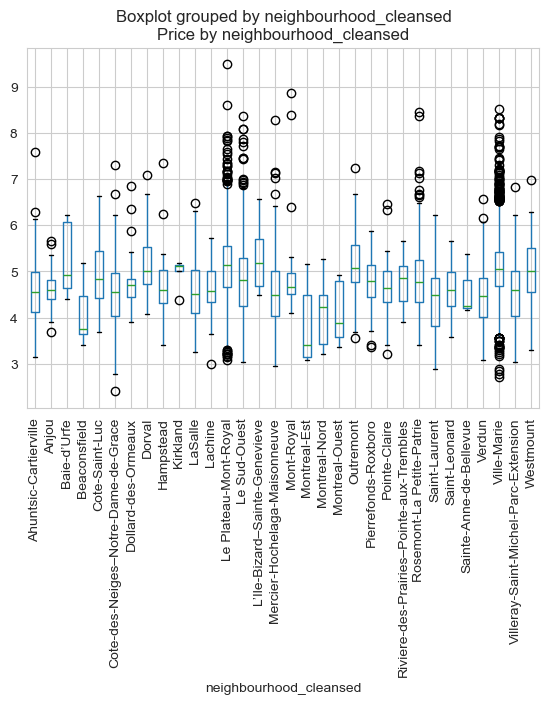

property_type
Entire chalet                         6.569481
Entire villa                          6.087653
Castle                                6.057858
Entire vacation home                  5.848764
Room in aparthotel                    5.645163
Entire townhouse                      5.622947
Entire cottage                        5.615264
Entire home                           5.471343
Entire loft                           5.181923
Room in boutique hotel                5.163585
Entire bungalow                       5.161537
Entire serviced apartment             5.155105
Entire condo                          5.060864
Entire rental unit                    5.001185
Entire place                          4.975186
Room in hotel                         4.962971
Private room in hostel                4.876918
Private room in bed and breakfast     4.875200
Religious building                    4.636262
Entire guest suite                    4.627409
Entire cabin                          4.574711

<Figure size 800x400 with 0 Axes>

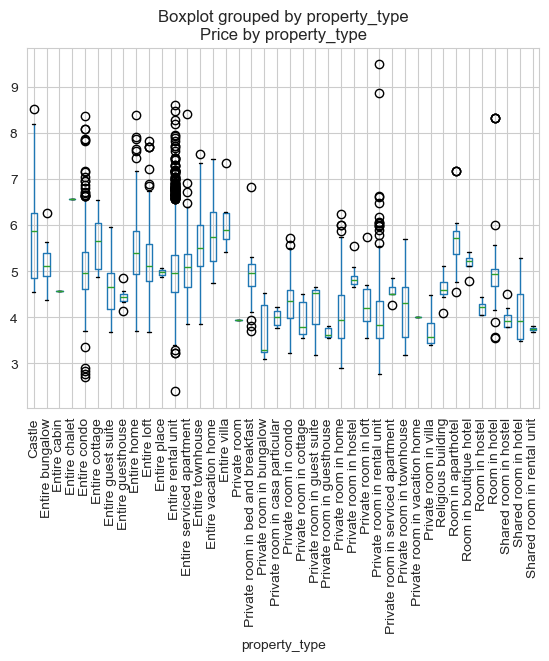

In [33]:
col = 'neighbourhood_cleansed'
avg_price = listings_clean.groupby(col)['price_log'].mean().sort_values(ascending=False)
print(avg_price)

plt.figure(figsize=(8,4))
listings_clean.boxplot(column='price_log', by=col)
plt.title(f'Price by {col}')
plt.xticks(rotation=90)
plt.show()

col = 'property_type'
avg_price = listings_clean.groupby(col)['price_log'].mean().sort_values(ascending=False)
print(avg_price)

plt.figure(figsize=(8,4))
listings_clean.boxplot(column='price_log', by=col)
plt.title(f'Price by {col}')
plt.xticks(rotation=90)
plt.show()



In [34]:
#Uses ANOVA statistical test to check if there is a diffference in 'price_log' across different categories of several categorical variables.
from scipy import stats
import pandas as pd

# List your categorical columns
# categorical_cols = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 
#                     'host_identity_verified', 'room_type', 'instant_bookable',
#                     'min_nights_bin', 'min_nights_regulation']

categorical_cols = listings_clean.select_dtypes(include=['object', 'category']).columns

# Loop through each categorical column
for col in categorical_cols:
    print(f"\n--- {col} ---")

    # Drop missing values
    temp = listings_clean[[col, 'price_log']].dropna()

    # If variable has only 2 categories, use a simple t-test
    if temp[col].nunique() == 2:
        groups = temp.groupby(col)['price_log']
        cats = list(groups.groups.keys())
        t_stat, p_val = stats.ttest_ind(groups.get_group(cats[0]),
                                        groups.get_group(cats[1]),
                                        equal_var=False)
        print(f"p-value: {p_val:.4f}")

    # If variable has more than 2 categories, use one-way ANOVA (still simple)
    else:
        groups = [g['price_log'].values for _, g in temp.groupby(col)]
        f_stat, p_val = stats.f_oneway(*groups)
        print(f"p-value: {p_val:.4f}")



--- host_is_superhost ---
p-value: 0.0000

--- host_has_profile_pic ---
p-value: 0.0005

--- host_identity_verified ---
p-value: 0.6074

--- neighbourhood_cleansed ---
p-value: 0.0000

--- property_type ---
p-value: 0.0000

--- room_type ---
p-value: 0.0000

--- amenities ---
p-value: 0.0000

--- instant_bookable ---
p-value: 0.0000

--- min_nights_bin ---
p-value: nan

--- min_nights_regulation ---
p-value: 0.0000


To statistically confirm the visual differences, we used t-tests (for binary categories) and F-tests (for multi-category ones).
Variables like room_type, host_response_time, and min_nights_regulation showed p-values below 0.05, indicating significant differences in price across their categories.
Others, such as host_identity_verified and instant_bookable, had non-significant p-values, suggesting limited or no effect on price.

## Variable Significance Summary (Numerical + Categorical)

| Variable | Type | r (correlation) | p-value | Interpretation | Keep/Drop |
|-----------|------|----------------|----------|----------------|------------|
| **accommodates** | Numeric | 0.617 | 0.0000 | Strong positive correlation — listings accommodating more guests tend to have higher prices | Keep |
| **beds** | Numeric | 0.520 | 0.0000 | Highly correlated with accommodates; redundant | Drop (keep accommodates) |
| **bedrooms** | Numeric | 0.502 | 0.0000 | Similar to beds; indicates capacity | Keep one of {beds, bedrooms} |
| **bathrooms** | Numeric | 0.342 | 0.0000 | Moderate positive effect on price | Keep |
| **minimum_nights** | Numeric | -0.219 | 0.0000 | Listings requiring longer stays are slightly cheaper | Keep |
| **maximum_nights** | Numeric | -0.006 | 0.544 | Not significant | Drop |
| **host_response_rate** | Numeric | 0.109 | 0.0000 | Weak but significant — faster-responding hosts may charge slightly more | Optional |
| **host_acceptance_rate** | Numeric | 0.186 | 0.0000 | Slight positive relationship | Optional |
| **number_of_reviews** | Numeric | -0.168 | 0.0000 | Weak negative — older or lower-priced listings tend to have more reviews | Optional |
| **number_of_reviews_log** | Numeric | 0.215 | 0.0000 | Weak to moderate relationship | Optional |
| **review_scores_rating** | Numeric | 0.124 | 0.0000 | Weak; quality may affect price slightly | Drop |
| **review_scores_value** | Numeric | 0.119 | 0.0000 | Weak; limited explanatory power | Drop |
| **review_scores_cleanliness** | Numeric | 0.150 | 0.0000 | Weak; minimal effect | Drop |
| **host_listings_count** | Numeric | -0.020 | 0.056 | Not significant | Drop |
| **calculated_host_listings_count** | Numeric | -0.020 | 0.064 | Not significant | Drop |

/

| Variable | Type | p-value | Interpretation | Keep/Drop |
|-----------|--------|----------|----------------|------------|
| **host_response_time** | Categorical | 0.0000 | Faster responses are associated with higher prices | Keep |
| **host_is_superhost** | Categorical | 0.0000 | Superhosts tend to charge higher prices | Keep |
| **host_has_profile_pic** | Categorical | 0.0005 | Listings with profile pictures are priced slightly higher | Keep |
| **host_identity_verified** | Categorical | 0.6080 | No meaningful difference in price | Drop |
| **room_type** | Categorical | 0.0000 | Major determinant of price differences | Keep |
| **instant_bookable** | Categorical | 0.0000 | Instant-bookable listings are slightly higher in price | Keep |
| **min_nights_bin** | Categorical | NaN | Test invalid (too few samples) | Drop |
| **min_nights_regulation** | Categorical | 0.0000 | Regulated listings are priced lower | Keep |


## Feature Engineering

### In this part, we 1\) create useful derived variables, 2\) we turn some continuous variables into categorical ones with binning, and 3\) we one-hot encode all categorical variables, whether binned or already-existing

Fixing 'min_nights_bin' to be ordinally encoded for model

In [35]:
# Create a new, model-ready column using the category codes
df['min_nights_encoded'] = df['min_nights_bin'].cat.codes

# You can now use 'min_nights_encoded' in your model
print(df[['min_nights_bin', 'min_nights_encoded']].head())

  min_nights_bin  min_nights_encoded
0            0-1                   0
1            0-1                   0
2            10+                   5
3            10+                   5
4            2-3                   1


### Creating new, transformed/derived features to enhance model performance

In [36]:
# Feature 1: Price per person - KEY VALUE METRIC FOR PRICE MODELING
# Rationale: Helps normalize price by capacity. A $200 listing for 10 people is different 
# from $200 for 2 people. This captures the per-guest value, which is what guests compare
# when choosing listings. Lower price-per-person = better value = competitive pricing.
listings_clean['price_per_person'] = listings_clean['price'] / listings_clean['accommodates']

# Feature 2: Room density - SPACE QUALITY INDICATOR FOR PRICE
# Rationale: Indicates space efficiency/crowding (beds per bedroom). Higher density 
# suggests less privacy (e.g., 4 beds in 1 bedroom = hostel-style). Lower density 
# suggests more spacious/luxury accommodations. Affects willingness to pay.
listings_clean['room_density'] = listings_clean['beds'] / listings_clean['bedrooms'].replace(0, 1)  # Avoid division by zero

# Feature 3: Host experience (in days) - TRUST & SERVICE QUALITY SIGNAL
# Rationale: More experienced hosts (longer on platform) may charge premium prices due to:
# - Better reviews/reputation built over time
# - Understanding of optimal pricing
# - Better service quality from experience
# This will be binned later into experience levels for non-linear modeling.

#Define date the dataset was last updated
target_date = pd.to_datetime('2025-06-26')

# 2. Calculate the difference (timedelta) and extract the number of days
listings_clean['host_experience_days'] = (target_date - listings_clean['host_since']).dt.days

# Feature 4: Availability rate - DEMAND/POPULARITY SIGNAL
# Rationale: Lower availability may indicate higher demand/bookings (property is busy).
# Higher availability may indicate lower demand or flexible hosting. Captures market dynamics.
# Will be binned later into availability tiers to capture non-linear threshold effects.
listings_clean['availability_rate'] = listings_clean['availability_365'] / 365

# Feature 5: Review recency - ACTIVITY & RELEVANCE SIGNAL
# Rationale: Recently reviewed listings are actively booking, suggesting current market 
# relevance. Stale listings (no recent reviews) might be inactive or overpriced. Signals
# current market engagement and can interact with other features.
listings_clean['days_since_last_review'] = (target_date - listings_clean['last_review']).dt.days

# Feature 6: Boolean conversions - CATEGORICAL QUALITY SIGNALS
# Rationale: Convert text ('t'/'f') to boolean for easier modeling. These are important
# categorical predictors: superhosts command premium, verified hosts build trust, etc.
listings_clean['host_is_superhost'] = listings['host_is_superhost'] == 't'
listings_clean['instant_bookable']= listings_clean['instant_bookable'] =='t'
listings_clean['host_has_profile_pic']= listings_clean['host_has_profile_pic'] =='t'
listings_clean['host_identity_verified']=listings_clean['host_identity_verified']=='t'


#Feature 7: Creating amenities count feature to capture value added by amenities
listings_clean['amenities_count'] = listings_clean['amenities'].apply(lambda x: len(x.strip('{}').split(',')))


print("New features created successfully!")
print("\nSample of new features:")
print(listings_clean[['price_per_person', 'room_density', 'host_experience_days', 
                'availability_rate', 'days_since_last_review', 'amenities_count']].head())

New features created successfully!

Sample of new features:
   price_per_person  room_density  host_experience_days  availability_rate  \
0         34.250000      3.000000                  5522           0.794521   
1         76.250000      1.000000                  5522           0.895890   
2         77.000000      2.000000                  5253           0.808219   
3         47.000000      1.333333                  5464           0.904110   
4         47.666667      2.000000                  5402           0.095890   

   days_since_last_review  amenities_count  
0                     6.0               58  
1                    10.0               68  
2                   299.0               29  
3                   299.0               21  
4                    10.0               49  


### Bin continuous variables with unequally-spaced thresholds to capture nonlinear effects at relevant thresholds

In [37]:
# BINNING CONTINUOUS VARIABLES FOR NON-LINEAR MODELING
# 
# WHY BINNING? Linear models assume constant effects (e.g., each additional guest adds $X).
# But real-world pricing is non-linear: difference between 1-2 guests is different from 7-8.
# Binning captures these threshold effects and non-linearities automatically.
#
# STRATEGY: We bin key continuous variables and DROP the originals to avoid redundancy.
# The model will learn different price effects for each bin through one-hot encoding.

# Bin 1: Property size - CAPTURES CAPACITY PRICING TIERS
# Why: Price doesn't scale linearly with guests. Small (1-2) = budget/couple, Medium (3-4) = small family,
# Large (5-6) = large family, Extra Large (7+) = group/event. Each tier has different pricing dynamics.
# Model benefit: Captures that going from 1→2 guests has different price impact than 7→8.
listings_clean['property_size'] = pd.cut(listings_clean['accommodates'],
                                          bins=[0, 2, 4, 6, float('inf')],
                                          labels=['Small', 'Medium', 'Large', 'Extra Large'])

# Bin 2: Host experience - CAPTURES EXPERIENCE-BASED PRICING POWER
# Why: New hosts (under-pricers) vs Veterans (optimal pricing knowledge). Non-linear relationship:
# New (<1yr) = learning, still building reputation, may underprice
# Intermediate (1-3yrs) = establishing reputation
# Experienced (3-5yrs) = strong reputation, optimal pricing
# Veteran (5+yrs) = maximum pricing power from reputation
# Model benefit: Each experience tier gets its own price coefficient.
listings_clean['host_experience_level'] = pd.cut(listings_clean['host_experience_days'],
                                                  bins=[0, 365, 1095, 1825, float('inf')],
                                                  labels=['New', 'Intermediate', 'Experienced', 'Veteran'])

# Bin 3: Review volume - CAPTURES POPULARITY-BASED PRICING TIERS
# Why: Reviews signal booking history. Threshold effects exist:
# None (0) = untested, risky → price discount
# Few (1-10) = some validation
# Moderate (11-50) = established
# Many (51-200) = very popular → can charge premium
# Very Many (200+) = top-tier → maximum premium
# Model benefit: Captures non-linear trust/popularity premium.
listings_clean['review_volume'] = pd.cut(listings_clean['number_of_reviews'],
                                          bins=[-1, 0, 10, 50, 200, float('inf')],
                                          labels=['None', 'Few', 'Moderate', 'Many', 'Very Many'])

# Bin 4: Availability tier - CAPTURES DEMAND DYNAMICS
# Why: Availability signals booking pressure. Non-linear:
# Low (<25%) = high demand, nearly fully booked → can charge premium
# Medium (25-50%) = healthy booking rate
# High (50-75%) = moderate demand
# Very High (75%+) = low demand, struggling to book → must discount
# Model benefit: Each tier represents different competitive position.
listings_clean['availability_tier'] = pd.cut(listings_clean['availability_rate'],
                                              bins=[0, 0.25, 0.50, 0.75, 1.0],
                                              labels=['Low', 'Medium', 'High', 'Very High'])

print("Binned features created successfully!")
print("\nDistribution of binned features:")
print(f"\nProperty size:\n{listings_clean['property_size'].value_counts().sort_index()}")
print(f"\nHost experience level:\n{listings_clean['host_experience_level'].value_counts().sort_index()}")
print(f"\nReview volume:\n{listings_clean['review_volume'].value_counts().sort_index()}")
print(f"\nAvailability tier:\n{listings_clean['availability_tier'].value_counts().sort_index()}")

# DROP ORIGINAL CONTINUOUS VERSIONS TO PREVENT MULTICOLLINEARITY
# Why: Using both continuous AND binned versions causes redundancy and inflates standard errors.
# The binned versions capture non-linear effects better for our pricing model.
print("\n--- Replacing continuous features with binned versions ---")
listings_clean = listings_clean.drop(columns=[
    'accommodates',           # replaced by property_size (captures capacity tiers)
    'host_experience_days',   # replaced by host_experience_level (captures experience tiers)
    'availability_rate'       # replaced by availability_tier (captures demand tiers)
], errors='ignore')

print("Dropped: accommodates, host_experience_days, availability_rate")
print(f"Remaining columns: {len(listings_clean.columns)}")
print("\nNote: number_of_reviews_log is kept alongside review_volume as they capture different aspects")
print("(log = continuous scale, volume = categorical tiers)")

Binned features created successfully!

Distribution of binned features:

Property size:
property_size
Small          3866
Medium         2580
Large          1412
Extra Large     916
Name: count, dtype: int64

Host experience level:
host_experience_level
New              699
Intermediate    1454
Experienced      972
Veteran         5649
Name: count, dtype: int64

Review volume:
review_volume
None         1604
Few          2826
Moderate     2165
Many         1779
Very Many     400
Name: count, dtype: int64

Availability tier:
availability_tier
Low          1887
Medium       1750
High         2278
Very High    2711
Name: count, dtype: int64

--- Replacing continuous features with binned versions ---
Dropped: accommodates, host_experience_days, availability_rate
Remaining columns: 43

Note: number_of_reviews_log is kept alongside review_volume as they capture different aspects
(log = continuous scale, volume = categorical tiers)


In [38]:
# ============================================================================
# VERIFICATION: Binned Features Replacement Summary
# ============================================================================

print("="*80)
print("BINNED FEATURES REPLACEMENT AUDIT")
print("="*80)

# Check what was dropped
dropped_features = ['accommodates', 'host_experience_days', 'availability_rate']
binned_features = ['property_size', 'host_experience_level', 'review_volume', 'availability_tier']

print("\n📊 REPLACEMENT SUMMARY:")
print("-" * 80)

replacement_table = {
    'Continuous Feature (DROPPED)': [
        'accommodates',
        'host_experience_days', 
        'availability_rate',
        '(none - kept number_of_reviews)'
    ],
    'Replaced By (BINNED)': [
        'property_size',
        'host_experience_level',
        'availability_tier',
        'review_volume'
    ],
    'Reason for Binning': [
        'Capture non-linear capacity pricing tiers',
        'Capture experience-based pricing power',
        'Capture demand dynamics',
        'Capture popularity premium thresholds'
    ]
}

import pandas as pd
replacement_df = pd.DataFrame(replacement_table)
print(replacement_df.to_string(index=False))

print("\n" + "="*80)
print("VERIFICATION CHECKS:")
print("="*80)

# Verify dropped features are gone
for feature in dropped_features:
    if feature in listings_clean.columns:
        print(f"⚠️  WARNING: '{feature}' still exists! Should have been dropped.")
    else:
        print(f"✓ CONFIRMED: '{feature}' successfully dropped")

# Verify binned features exist
print()
for feature in binned_features:
    if feature in listings_clean.columns:
        print(f"✓ CONFIRMED: '{feature}' exists")
    else:
        print(f"⚠️  WARNING: '{feature}' missing! Should exist.")

# Count current columns
print("\n" + "="*80)
print("COLUMN COUNT PROGRESSION:")
print("="*80)
print(f"Baseline (after cleaning): 36 columns")
print(f"After continuous features: 36 + 5 = 41 columns")
print(f"After binning & dropping: 41 + 4 - 3 = 42 columns")
print(f"Current columns in listings_clean: {len(listings_clean.columns)}")

if len(listings_clean.columns) == 42:
    print("✓ CONFIRMED: Column count is correct!")
else:
    print(f"⚠️  WARNING: Expected 42 columns, found {len(listings_clean.columns)}")
    
print("\n" + "="*80)
print("FINAL FEATURE LIST IN listings_clean:")
print("="*80)
print(sorted(listings_clean.columns.tolist()))
print("\n" + "="*80)

BINNED FEATURES REPLACEMENT AUDIT

📊 REPLACEMENT SUMMARY:
--------------------------------------------------------------------------------
   Continuous Feature (DROPPED)  Replaced By (BINNED)                        Reason for Binning
                   accommodates         property_size Capture non-linear capacity pricing tiers
           host_experience_days host_experience_level    Capture experience-based pricing power
              availability_rate     availability_tier                   Capture demand dynamics
(none - kept number_of_reviews)         review_volume     Capture popularity premium thresholds

VERIFICATION CHECKS:
✓ CONFIRMED: 'accommodates' successfully dropped
✓ CONFIRMED: 'host_experience_days' successfully dropped
✓ CONFIRMED: 'availability_rate' successfully dropped

✓ CONFIRMED: 'property_size' exists
✓ CONFIRMED: 'host_experience_level' exists
✓ CONFIRMED: 'review_volume' exists
✓ CONFIRMED: 'availability_tier' exists

COLUMN COUNT PROGRESSION:
Baseline (after

### One hot encoding categorical variables

In [39]:
listings_clean.dtypes

host_since                        datetime64[ns]
host_response_time                       float64
host_response_rate                       float64
host_acceptance_rate                     float64
host_is_superhost                           bool
host_listings_count                        int64
host_has_profile_pic                        bool
host_identity_verified                      bool
neighbourhood_cleansed                    object
property_type                             object
room_type                                 object
bathrooms                                float64
bedrooms                                 float64
beds                                     float64
amenities                                 object
price                                    float64
minimum_nights                             int64
maximum_nights                             int64
availability_365                           int64
number_of_reviews                          int64
last_review         

In [40]:
# One-hot encoding of categorical variables for regression modeling
# This converts categorical text into binary (0/1) columns that regression can use
# drop_first=True removes one category per variable to avoid multicollinearity (dummy variable trap)

columns_to_encode = [
    'neighbourhood_cleansed',      # Montreal neighborhoods (32 areas)
    'min_nights_regulation',       # Regulated vs not regulated (Montreal 31-night rule)
    'host_response_time',          # Response speed categories
    'room_type',                   # Entire home, private room, etc.
    'property_size',               # Small, Medium, Large, Extra Large (binned)
    'host_experience_level',       # New, Intermediate, Experienced, Veteran (binned)
    'review_volume',               # None, Few, Moderate, Many, Very Many (binned)
    'availability_tier'            # Low, Medium, High, Very High (binned)
]

columns_to_encode_prefixes = [
    'neighbourhood_is',
    'min_nights_is',
    'host_response_time_is',
    'room_type_is',
    'property_size_is',
    'host_experience_is',
    'review_volume_is',
    'availability_is'
]

# Create the encoded dataframe
listings_encoded = pd.get_dummies(
    listings_clean,
    columns=columns_to_encode,
    prefix=columns_to_encode_prefixes,
    drop_first=True
)

print(f"One-hot encoding complete!")
print(f"Original columns: {len(listings_clean.columns)}")
print(f"Encoded columns: {len(listings_encoded.columns)}")
print(f"New dummy variables created: {len(listings_encoded.columns) - len(listings_clean.columns) + len(columns_to_encode)}")

# Display the dataframe
pd.set_option('display.max_columns', None)
listings_encoded.head()

One-hot encoding complete!
Original columns: 43
Encoded columns: 86
New dummy variables created: 51


,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,min_nights_bin,regulated,price_log,number_of_reviews_log,price_per_person,room_density,days_since_last_review,amenities_count,neighbourhood_is_Anjou,neighbourhood_is_Baie-d’Urfe,neighbourhood_is_Beaconsfield,neighbourhood_is_Cote-Saint-Luc,neighbourhood_is_Cote-des-Neiges–Notre-Dame-de-Grace,neighbourhood_is_Dollard-des-Ormeaux,neighbourhood_is_Dorval,neighbourhood_is_Hampstead,neighbourhood_is_Kirkland,neighbourhood_is_LaSalle,neighbourhood_is_Lachine,neighbourhood_is_Le Plateau-Mont-Royal,neighbourhood_is_Le Sud-Ouest,neighbourhood_is_L’Ile-Bizard–Sainte-Genevieve,neighbourhood_is_Mercier-Hochelaga-Maisonneuve,neighbourhood_is_Mont-Royal,neighbourhood_is_Montreal-Est,neighbourhood_is_Montreal-Nord,neighbourhood_is_Montreal-Ouest,neighbourhood_is_Outremont,neighbourhood_is_Pierrefonds-Roxboro,neighbourhood_is_Pointe-Claire,neighbourhood_is_Riviere-des-Prairies–Pointe-aux-Trembles,neighbourhood_is_Rosemont-La Petite-Patrie,neighbourhood_is_Saint-Laurent,neighbourhood_is_Saint-Leonard,neighbourhood_is_Sainte-Anne-de-Bellevue,neighbourhood_is_Verdun,neighbourhood_is_Ville-Marie,neighbourhood_is_Villeray-Saint-Michel-Parc-Extension,neighbourhood_is_Westmount,min_nights_is_regulated,host_response_time_is_3.0,host_response_time_is_24.0,host_response_time_is_72.0,room_type_is_Hotel room,room_type_is_Private room,room_type_is_Shared room,property_size_is_Medium,property_size_is_Large,property_size_is_Extra Large,host_experience_is_Intermediate,host_experience_is_Experienced,host_experience_is_Veteran,review_volume_is_Few,review_volume_is_Moderate,review_volume_is_Many,review_volume_is_Very Many,availability_is_Medium,availability_is_High,availability_is_Very High
0,2010-05-14,100.0,100.0,True,2,True,True,Entire rental unit,1.0,1.0,3.0,"[""Hair dryer"", ""Hot water kettle"", ""Crib - ava...",137.0,31,60,290,487,2025-06-20,4.68,4.79,4.63,4.82,4.78,4.82,4.67,False,2,0-1,1,4.919981,6.190315,34.250000,3.000000,6.0,58,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True
1,2010-05-14,100.0,100.0,True,2,True,True,Entire home,1.0,2.0,2.0,"[""Hair dryer"", ""Hot water kettle"", ""Coffee mak...",305.0,2,21,327,156,2025-06-16,4.75,4.84,4.68,4.88,4.83,4.87,4.72,False,2,0-1,0,5.720312,5.056246,76.250000,1.000000,10.0,68,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True
2,2011-02-07,90.0,56.0,True,8,True,True,Entire rental unit,1.0,1.0,2.0,"[""Hair dryer"", ""Wifi"", ""Indoor fireplace"", ""Pa...",154.0,210,365,295,52,2024-08-31,4.87,4.88,4.87,4.92,4.90,4.88,4.77,False,8,10+,1,5.036953,3.970292,77.000000,2.000000,299.0,29,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True
3,2010-07-11,0.0,6.0,False,3,True,True,Private room in rental unit,1.0,3.0,4.0,"[""Hair dryer"", ""Wifi"", ""Patio or balcony"", ""Dr...",47.0,31,60,330,17,2024-08-31,4.53,4.53,4.2

### Creating Interaction Terms to capture complex causality (involving multiple variables)

Interaction terms capture how the effect of one variable depends on the value of another variable. These can reveal important non-linear relationships that individual features alone cannot capture.

For example:
- A superhost with many reviews might command a higher premium than just the sum of "being a superhost" + "having reviews"
- The value of instant booking might be different for properties with high vs low availability

We create 6 key interactions based on domain knowledge of what matters in Airbnb pricing.

In [41]:
# Creating interaction terms to capture non-linear relationships
# Interactions help model how one variable's effect depends on another

# Interaction 1: Superhost premium might vary with review volume
# Superhosts with many reviews might command an even higher premium
listings_encoded['superhost_x_reviews'] = (
    listings_encoded['host_is_superhost'].astype(int) * 
    listings_clean['number_of_reviews_log']
)

# Interaction 2: Price per person might vary with property density
# How crowded a space is might affect per-person value differently
listings_encoded['price_per_person_x_density'] = (
    listings_clean['price_per_person'] * 
    listings_clean['room_density']
)

# Interaction 3: Instant bookable and minimum nights regulation
# Instant bookable might matter more for regulated vs non-regulated properties
# We'll need to create a numeric version of min_nights_regulation for multiplication
regulated_numeric = (listings_clean['min_nights_regulation'] == 'regulated').astype(int)
listings_encoded['instant_x_regulated'] = (
    listings_encoded['instant_bookable'].astype(int) * 
    regulated_numeric
)

# Interaction 4: Bedrooms and bathrooms (space-luxury interaction)
# More bathrooms relative to bedrooms indicates luxury/quality
listings_encoded['bedrooms_x_bathrooms'] = (
    listings_clean['bedrooms'] * 
    listings_clean['bathrooms']
)

# Interaction 5: Review recency and volume (activity indicator)
# Recently reviewed high-volume listings are very active
listings_encoded['review_recency_x_volume'] = (
    listings_clean['days_since_last_review'].fillna(999) * 
    listings_clean['number_of_reviews_log']
)

# Interaction 6: Response time and superhost (service quality indicator)
# Fast-responding superhosts might command a premium
# Create numeric encoding for fast response (within an hour or few hours)
host_response_fast = listings_clean['host_response_time'].isin(['within an hour', 'within a few hours']).astype(int)
listings_encoded['superhost_x_fast_response'] = (
    listings_encoded['host_is_superhost'].astype(int) * 
    host_response_fast
)

print("Interaction terms created successfully!")
print(f"\nTotal columns in listings_encoded: {len(listings_encoded.columns)}")
print("\nNew interaction columns:")
print("- superhost_x_reviews")
print("- price_per_person_x_density")
print("- instant_x_regulated")
print("- bedrooms_x_bathrooms")
print("- review_recency_x_volume")
print("- superhost_x_fast_response")

Interaction terms created successfully!

Total columns in listings_encoded: 92

New interaction columns:
- superhost_x_reviews
- price_per_person_x_density
- instant_x_regulated
- bedrooms_x_bathrooms
- review_recency_x_volume
- superhost_x_fast_response


In [42]:
# ============================================================================
# FINAL MODEL FEATURE COUNT
# ============================================================================

print("="*80)
print("FINAL MODEL FEATURES FOR REGRESSION")
print("="*80)

print(f"\nTotal columns in listings_encoded (after one-hot encoding): {len(listings_encoded.columns)}")
print(f"Total columns after interaction terms: {len(listings_encoded.columns)} (6 interactions already added)")

# Count by type
continuous_features = ['price_per_person', 'room_density', 'days_since_last_review', 
                      'number_of_reviews_log', 'price_log', 'host_response_rate', 
                      'host_acceptance_rate', 'bathrooms', 'bedrooms', 'beds',
                      'minimum_nights', 'maximum_nights', 'availability_365', 
                      'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                      'review_scores_cleanliness', 'review_scores_checkin', 
                      'review_scores_communication', 'review_scores_location', 
                      'review_scores_value', 'host_listings_count', 
                      'calculated_host_listings_count']

boolean_features = ['host_is_superhost', 'instant_bookable', 
                   'host_has_profile_pic', 'host_identity_verified']

interaction_features = ['superhost_x_reviews', 'price_per_person_x_density', 
                       'instant_x_regulated', 'bedrooms_x_bathrooms',
                       'review_recency_x_volume', 'superhost_x_fast_response']

# Count one-hot encoded dummy variables
dummy_cols = [col for col in listings_encoded.columns 
              if any(prefix in col for prefix in ['neighbourhood_is', 'min_nights_is', 
                                                   'host_response_time_is', 'room_type_is',
                                                   'property_size_is', 'host_experience_is',
                                                   'review_volume_is', 'availability_is'])]

print("\n" + "="*80)
print("FEATURE BREAKDOWN:")
print("="*80)
print(f"Continuous features: {len([c for c in continuous_features if c in listings_encoded.columns])}")
print(f"Boolean features: {len([c for c in boolean_features if c in listings_encoded.columns])}")
print(f"One-hot encoded dummies: {len(dummy_cols)}")
print(f"Interaction terms: {len([c for c in interaction_features if c in listings_encoded.columns])}")
print(f"\nTOTAL FEATURES: {len(listings_encoded.columns)}")

print("\n" + "="*80)
print("✓ Feature engineering complete and verified!")
print("✓ No redundant continuous/binned feature pairs exist")
print("✓ All binned features properly replaced their continuous equivalents")
print("="*80)

FINAL MODEL FEATURES FOR REGRESSION

Total columns in listings_encoded (after one-hot encoding): 92
Total columns after interaction terms: 92 (6 interactions already added)

FEATURE BREAKDOWN:
Continuous features: 23
Boolean features: 4
One-hot encoded dummies: 51
Interaction terms: 6

TOTAL FEATURES: 92

✓ Feature engineering complete and verified!
✓ No redundant continuous/binned feature pairs exist
✓ All binned features properly replaced their continuous equivalents


## Feature Engineering Summary

This section provides a comprehensive overview of all features engineered for the price prediction model.

### Feature Engineering Pipeline:
1. **Continuous Features** - Derived metrics that capture value, quality, and activity signals
2. **Boolean Features** - Binary indicators for categorical quality attributes  
3. **Binned Categorical Features** - Non-linear threshold effects for capacity, experience, popularity, demand
4. **One-Hot Encoding** - Convert categorical features to binary dummy variables
5. **Interaction Terms** - Capture how pricing factors depend on each other

### Why This Approach?
- **Non-linearity**: Binning captures threshold effects (e.g., 1→2 guests ≠ 7→8 guests in pricing impact)
- **Interpretability**: Categorical bins are easier to explain than continuous coefficients
- **Interactions**: Real pricing isn't additive - effects multiply (superhost + many reviews > sum of parts)
- **Model Performance**: Engineered features give the model more signal about what drives price

The visualizations below show how each engineered feature relates to price (log scale).

FEATURE ENGINEERING SUMMARY FOR PRICE PREDICTION MODEL

ENGINEERED FEATURES TABLE
      Feature Type               Feature Name                                     Purpose for Price Model
        Continuous           price_per_person                     Value per guest - normalize by capacity
        Continuous               room_density                        Space quality - crowding vs spacious
        Continuous     days_since_last_review                           Activity signal - recent bookings
Binned Categorical              property_size Capture non-linear capacity pricing (Small/Med/Large tiers)
Binned Categorical      host_experience_level            Capture experience-based pricing power (New/Vet)
Binned Categorical              review_volume               Capture popularity premium (Few/Many reviews)
Binned Categorical          availability_tier           Capture demand dynamics (High demand = low avail)
           Boolean          host_is_superhost                         

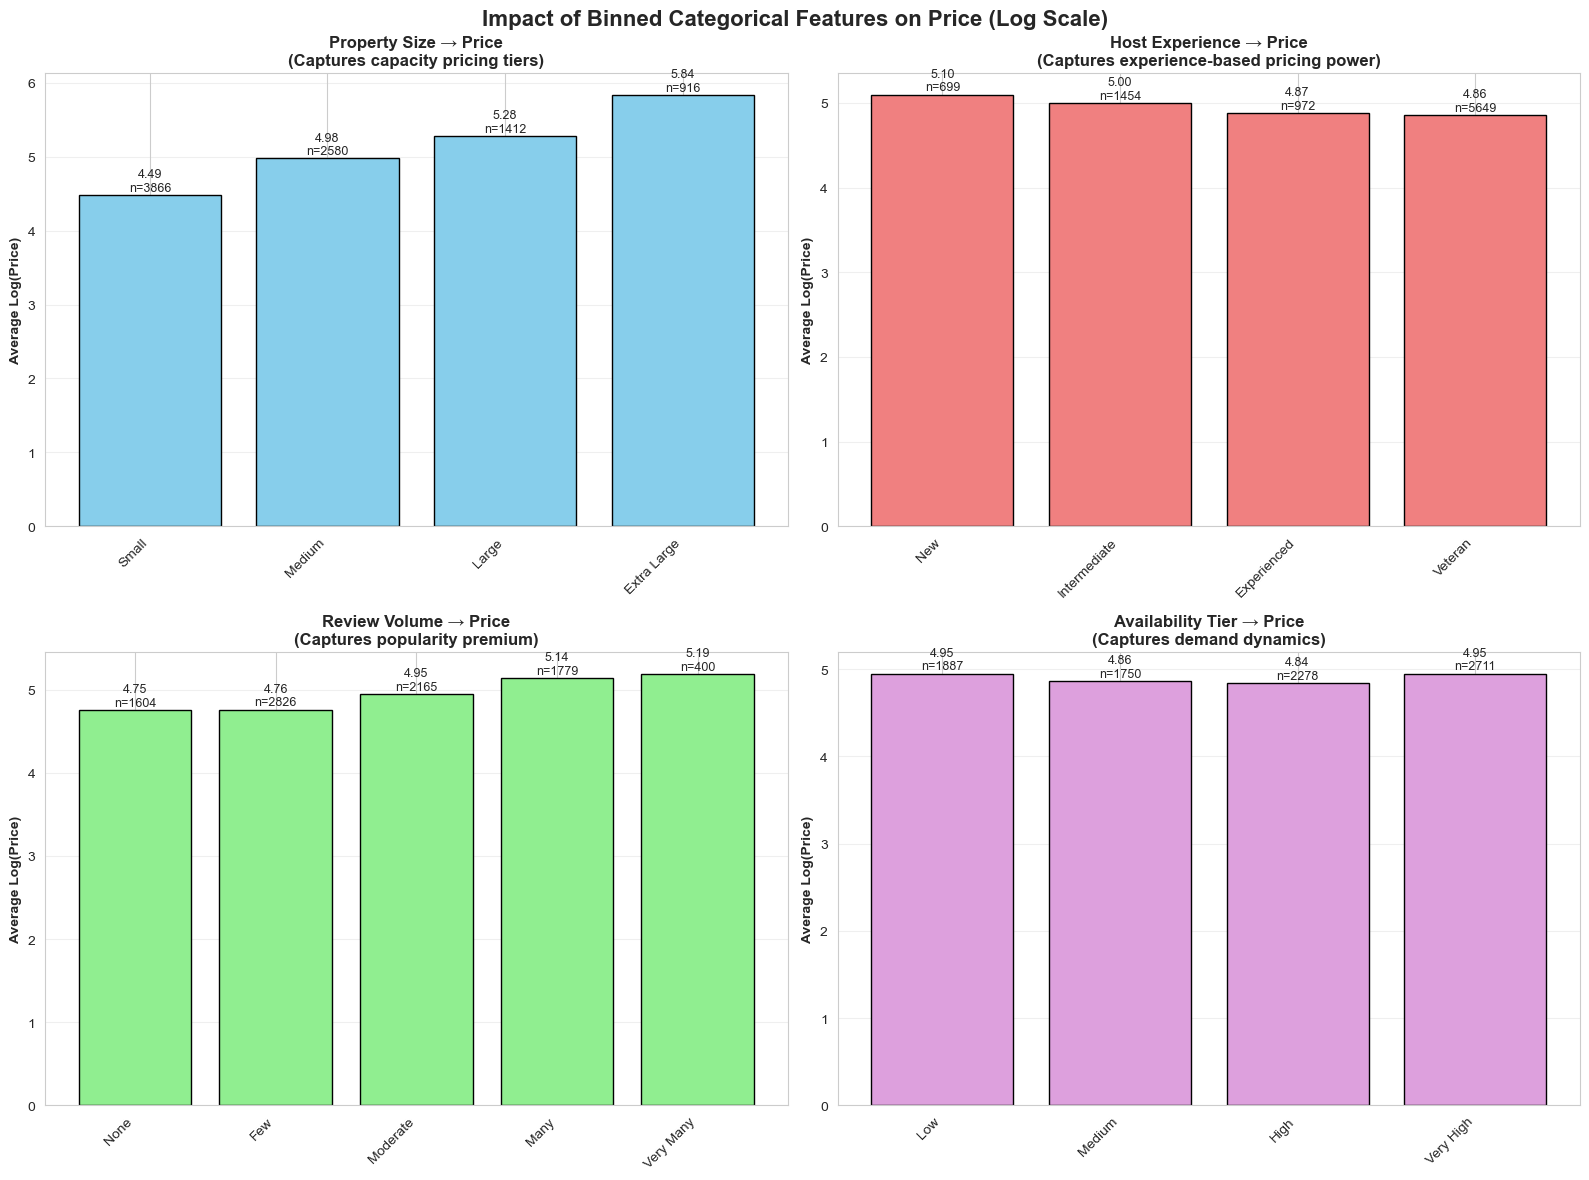

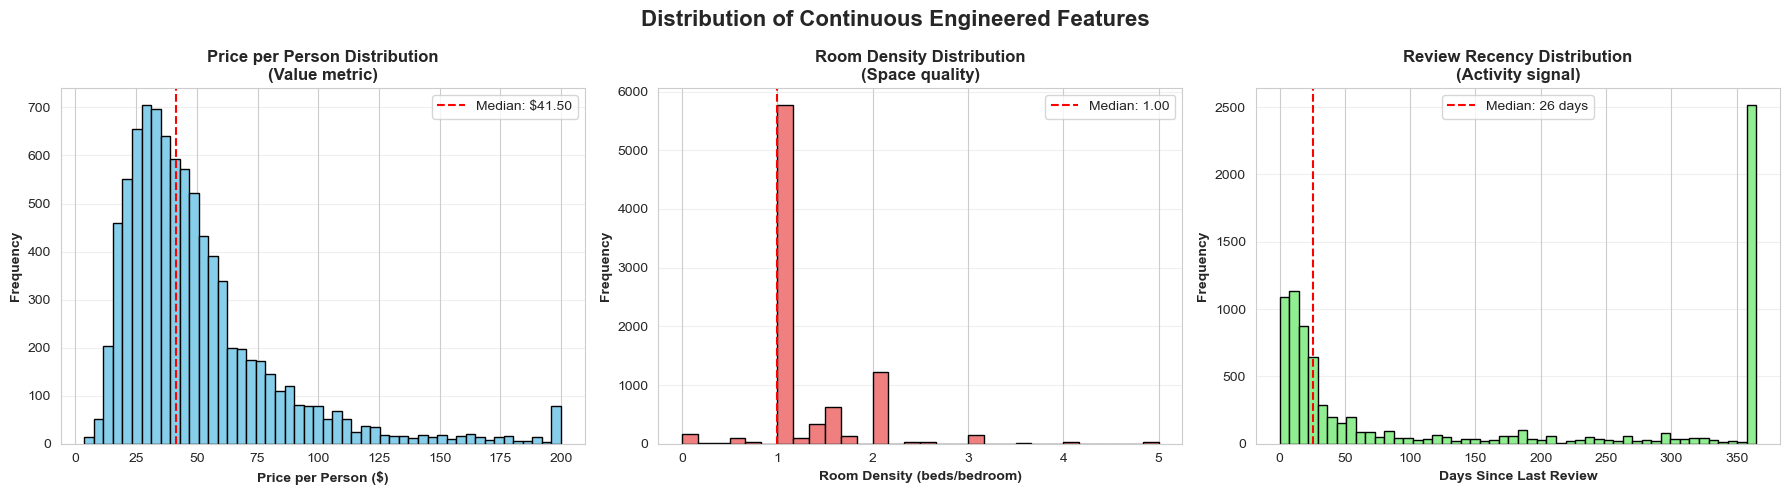


KEY INSIGHTS FOR PRICE MODELING
✓ Created 17 engineered features (3 continuous, 4 binned, 4 boolean, 6 interactions)
✓ Binned features capture non-linear threshold effects in pricing
✓ Interaction terms capture how pricing factors depend on each other
✓ All features are designed to improve price prediction accuracy
✓ One-hot encoding will create 18 binary dummy variables from binned/categorical features



In [43]:
# ============================================================================
# FEATURE ENGINEERING SUMMARY & VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("FEATURE ENGINEERING SUMMARY FOR PRICE PREDICTION MODEL")
print("="*80)

# Summary of all engineered features
feature_summary = {
    'Feature Type': [
        'Continuous', 'Continuous', 'Continuous', 
        'Binned Categorical', 'Binned Categorical', 'Binned Categorical', 'Binned Categorical',
        'Boolean', 'Boolean', 'Boolean', 'Boolean',
        'Interaction', 'Interaction', 'Interaction', 'Interaction', 'Interaction', 'Interaction'
    ],
    'Feature Name': [
        'price_per_person', 'room_density', 'days_since_last_review',
        'property_size', 'host_experience_level', 'review_volume', 'availability_tier',
        'host_is_superhost', 'instant_bookable', 'host_has_profile_pic', 'host_identity_verified',
        'superhost_x_reviews', 'price_per_person_x_density', 'instant_x_regulated', 
        'bedrooms_x_bathrooms', 'review_recency_x_volume', 'superhost_x_fast_response'
    ],
    'Purpose for Price Model': [
        'Value per guest - normalize by capacity',
        'Space quality - crowding vs spacious',
        'Activity signal - recent bookings',
        'Capture non-linear capacity pricing (Small/Med/Large tiers)',
        'Capture experience-based pricing power (New/Vet)',
        'Capture popularity premium (Few/Many reviews)',
        'Capture demand dynamics (High demand = low avail)',
        'Superhost premium indicator',
        'Convenience premium',
        'Trust/credibility signal',
        'Verification signal',
        'Superhost premium scales with reputation',
        'Value perception varies with crowding',
        'Booking ease varies by regulation',
        'Space-luxury interaction',
        'Activity-popularity interaction',
        'Service quality interaction'
    ]
}

import pandas as pd
summary_df = pd.DataFrame(feature_summary)
print("\n" + "="*80)
print("ENGINEERED FEATURES TABLE")
print("="*80)
print(summary_df.to_string(index=False))

# Visualization 1: Binned Features vs Price
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Impact of Binned Categorical Features on Price (Log Scale)', fontsize=16, fontweight='bold')

# Property size vs price
ax1 = axes[0, 0]
property_price = listings_clean.groupby('property_size')['price_log'].agg(['mean', 'count'])
ax1.bar(range(len(property_price)), property_price['mean'], color='skyblue', edgecolor='black')
ax1.set_xticks(range(len(property_price)))
ax1.set_xticklabels(property_price.index, rotation=45, ha='right')
ax1.set_ylabel('Average Log(Price)', fontweight='bold')
ax1.set_title('Property Size → Price\n(Captures capacity pricing tiers)', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (val, count) in enumerate(zip(property_price['mean'], property_price['count'])):
    ax1.text(i, val + 0.05, f'{val:.2f}\nn={count}', ha='center', fontsize=9)

# Host experience vs price
ax2 = axes[0, 1]
exp_price = listings_clean.groupby('host_experience_level')['price_log'].agg(['mean', 'count'])
ax2.bar(range(len(exp_price)), exp_price['mean'], color='lightcoral', edgecolor='black')
ax2.set_xticks(range(len(exp_price)))
ax2.set_xticklabels(exp_price.index, rotation=45, ha='right')
ax2.set_ylabel('Average Log(Price)', fontweight='bold')
ax2.set_title('Host Experience → Price\n(Captures experience-based pricing power)', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, (val, count) in enumerate(zip(exp_price['mean'], exp_price['count'])):
    ax2.text(i, val + 0.05, f'{val:.2f}\nn={count}', ha='center', fontsize=9)

# Review volume vs price
ax3 = axes[1, 0]
review_price = listings_clean.groupby('review_volume')['price_log'].agg(['mean', 'count'])
ax3.bar(range(len(review_price)), review_price['mean'], color='lightgreen', edgecolor='black')
ax3.set_xticks(range(len(review_price)))
ax3.set_xticklabels(review_price.index, rotation=45, ha='right')
ax3.set_ylabel('Average Log(Price)', fontweight='bold')
ax3.set_title('Review Volume → Price\n(Captures popularity premium)', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, (val, count) in enumerate(zip(review_price['mean'], review_price['count'])):
    ax3.text(i, val + 0.05, f'{val:.2f}\nn={count}', ha='center', fontsize=9)

# Availability tier vs price
ax4 = axes[1, 1]
avail_price = listings_clean.groupby('availability_tier')['price_log'].agg(['mean', 'count'])
ax4.bar(range(len(avail_price)), avail_price['mean'], color='plum', edgecolor='black')
ax4.set_xticks(range(len(avail_price)))
ax4.set_xticklabels(avail_price.index, rotation=45, ha='right')
ax4.set_ylabel('Average Log(Price)', fontweight='bold')
ax4.set_title('Availability Tier → Price\n(Captures demand dynamics)', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, (val, count) in enumerate(zip(avail_price['mean'], avail_price['count'])):
    ax4.text(i, val + 0.05, f'{val:.2f}\nn={count}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Visualization 2: Continuous Features Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Continuous Engineered Features', fontsize=16, fontweight='bold')

# Price per person
ax1 = axes[0]
listings_clean['price_per_person'].clip(0, 200).hist(bins=50, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('Price per Person ($)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Price per Person Distribution\n(Value metric)', fontweight='bold')
ax1.axvline(listings_clean['price_per_person'].median(), color='red', linestyle='--', 
            label=f'Median: ${listings_clean["price_per_person"].median():.2f}')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Room density
ax2 = axes[1]
listings_clean['room_density'].clip(0, 5).hist(bins=30, ax=ax2, color='lightcoral', edgecolor='black')
ax2.set_xlabel('Room Density (beds/bedroom)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Room Density Distribution\n(Space quality)', fontweight='bold')
ax2.axvline(listings_clean['room_density'].median(), color='red', linestyle='--',
            label=f'Median: {listings_clean["room_density"].median():.2f}')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Days since last review (capped for visualization)
ax3 = axes[2]
listings_clean['days_since_last_review'].fillna(999).clip(0, 365).hist(bins=50, ax=ax3, 
                                                                        color='lightgreen', edgecolor='black')
ax3.set_xlabel('Days Since Last Review', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Review Recency Distribution\n(Activity signal)', fontweight='bold')
ax3.axvline(listings_clean['days_since_last_review'].median(), color='red', linestyle='--',
            label=f'Median: {listings_clean["days_since_last_review"].median():.0f} days')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("KEY INSIGHTS FOR PRICE MODELING")
print("="*80)
print(f"✓ Created {len(summary_df)} engineered features (3 continuous, 4 binned, 4 boolean, 6 interactions)")
print(f"✓ Binned features capture non-linear threshold effects in pricing")
print(f"✓ Interaction terms capture how pricing factors depend on each other")
print(f"✓ All features are designed to improve price prediction accuracy")
print(f"✓ One-hot encoding will create {4 + 4 + 4 + 6} binary dummy variables from binned/categorical features")
print("\n" + "="*80)

## Model Fitting

## Assumption Checks

In [44]:
listings_encoded.dtypes

host_since                    datetime64[ns]
host_response_rate                   float64
host_acceptance_rate                 float64
host_is_superhost                       bool
host_listings_count                    int64
                                   ...      
price_per_person_x_density           float64
instant_x_regulated                    int64
bedrooms_x_bathrooms                 float64
review_recency_x_volume              float64
superhost_x_fast_response              int64
Length: 92, dtype: object

In [45]:
listings_encoded.dtypes.value_counts()
non_numeric = listings_encoded.select_dtypes(exclude=['number', 'bool'])
print(non_numeric.columns)


Index(['host_since', 'property_type', 'amenities', 'last_review',
       'min_nights_bin'],
      dtype='object')


In [46]:
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Columns you want to exclude from modeling/assumption checks
exclude_cols = ['price_log','host_since', 'property_type', 'amenities', 'last_review', 'min_nights_bin']

# 1) Start from your encoded DF
X_full = listings_encoded.copy()

# 2) Drop the non-numeric / unwanted columns
X = X_full.drop(columns=exclude_cols, errors='ignore')

# 3) Keep only number-like and bool dtypes
X = X.select_dtypes(include=['number', 'bool'])

# 4) Explicitly cast everything to float64 to avoid pandas extension dtypes / bool issues
X = X.astype('float64')

# Target: make sure this is numeric too
y = listings_clean['price_log']      # or listings_clean['Log_price']
y = pd.to_numeric(y, errors='coerce').astype('float64')

# 5) Align and drop rows with missing values in X or y
X, y = X.align(y, join='inner', axis=0)
mask = (~X.isna().any(axis=1)) & (~y.isna())
X = X.loc[mask]
y = y.loc[mask]

# 6) Add constant and fit model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

fitted = model.fittedvalues
residuals = model.resid


                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     302.4
Date:                Sun, 16 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:16:09   Log-Likelihood:                -2627.9
No. Observations:                7170   AIC:                             5424.
Df Residuals:                    7086   BIC:                             6001.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

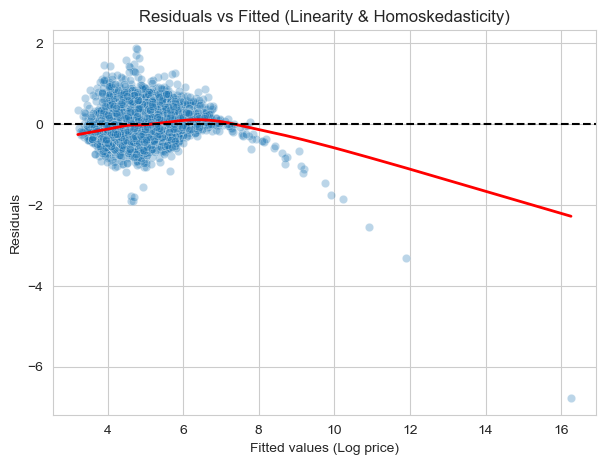

In [47]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Residuals vs fitted
plt.figure(figsize=(7,5))
sns.scatterplot(x=fitted, y=residuals, alpha=0.3)
smooth = lowess(residuals, fitted, frac=0.6)
plt.plot(smooth[:,0], smooth[:,1], color='red', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Fitted values (Log price)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (Linearity & Homoskedasticity)')
plt.show()


This residuals‑vs‑fitted plot shows a clear violation of the linearity assumption and likely heteroskedasticity at higher fitted prices.

The LOWESS line bends downward as fitted Log_price increases, meaning residuals are systematically negative for expensive listings (model underpredicts high prices and overpredicts mid‑range), so the relationship between predictors and Log_price is not purely linear.

The spread of residuals also grows and tilts for larger fitted values (a funnel/curve rather than a random cloud around zero), indicating non‑constant error variance in the upper tail.

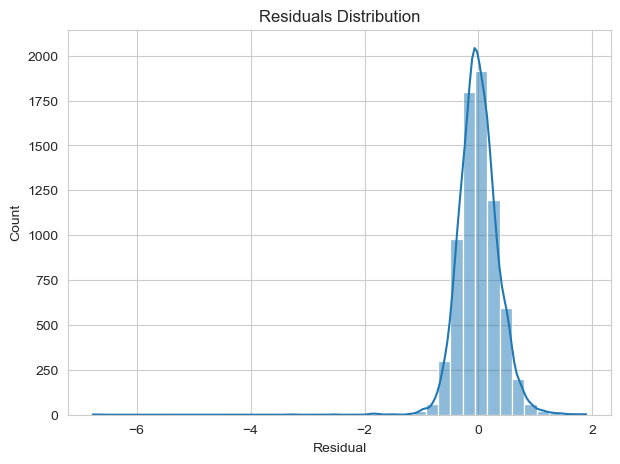

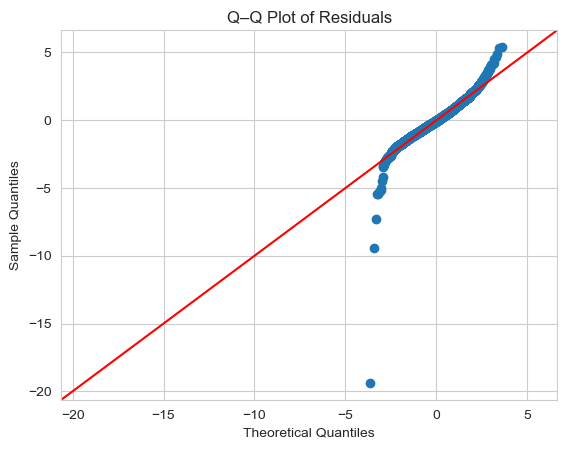

Jarque-Bera stat: 149545.995, p-value: 0, skew: -0.963, kurtosis: 25.290


In [48]:

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.stattools import jarque_bera, durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Histogram + KDE
plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True, bins=40)
plt.xlabel('Residual')
plt.title('Residuals Distribution')
plt.show()

# Q–Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q–Q Plot of Residuals')
plt.show()

# Jarque–Bera normality test
jb_stat, jb_p, skew, kurt = jarque_bera(residuals)
print(f"Jarque-Bera stat: {jb_stat:.3f}, p-value: {jb_p:.3g}, skew: {skew:.3f}, kurtosis: {kurt:.3f}")


Confirmation of Non-normal residuals

In [49]:
# Visual check already in residuals vs fitted (above)

# Breusch–Pagan test for heteroskedasticity
bp_stat, bp_p, bp_f, bp_fp = het_breuschpagan(residuals, model.model.exog)
print(f"Breusch-Pagan LM stat: {bp_stat:.3f}, LM p-value: {bp_p:.4f}, "
      f"F stat: {bp_f:.3f}, F p-value: {bp_fp:.4f}")


Breusch-Pagan LM stat: 5969.615, LM p-value: 0.0000, F stat: 424.570, F p-value: 0.0000


Strong evidence of heteroskedasticity in the residuals

In [50]:
# Durbin–Watson test
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.3f}")


Durbin-Watson: 1.749


Durbin–Watson (independence)

DW ≈ 1.75 is reasonably close to 2 and within the common “roughly OK” band 1.5–2.5, so there is at most mild positive autocorrelation and no serious violation of residual independence.

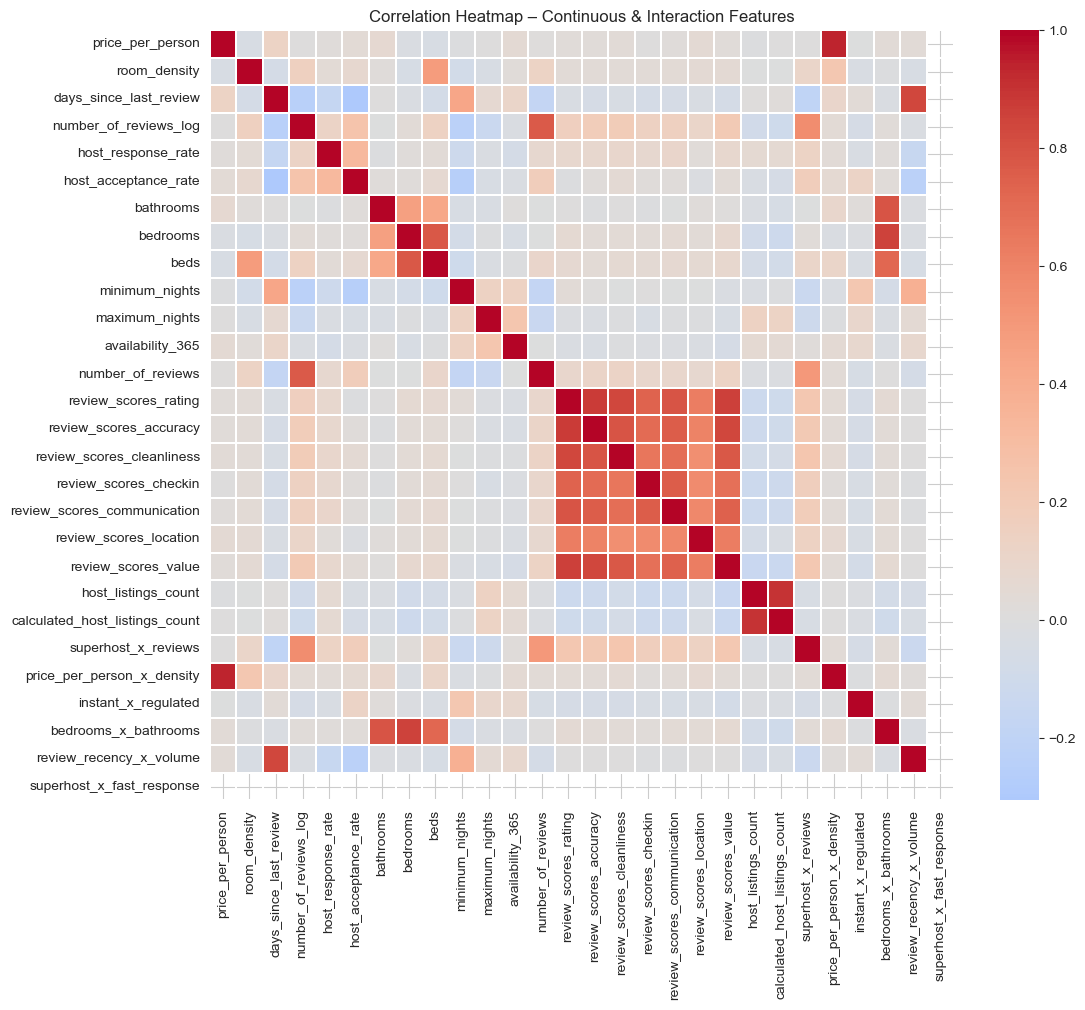

                           feature         VIF
0                            const  424.149728
24      price_per_person_x_density   23.284080
1                 price_per_person   22.171808
26            bedrooms_x_bathrooms   14.033610
8                         bedrooms    9.494068
9                             beds    9.382410
14            review_scores_rating    7.595800
22  calculated_host_listings_count    5.462357
21             host_listings_count    5.399013
15          review_scores_accuracy    5.295568
2                     room_density    5.239556
20             review_scores_value    4.779813
3           days_since_last_review    4.753716
7                        bathrooms    4.642168
27         review_recency_x_volume    4.297893
16       review_scores_cleanliness    3.643839
18     review_scores_communication    3.494392
4            number_of_reviews_log    3.445535
17           review_scores_checkin    2.809703
13               number_of_reviews    2.643827
19          r

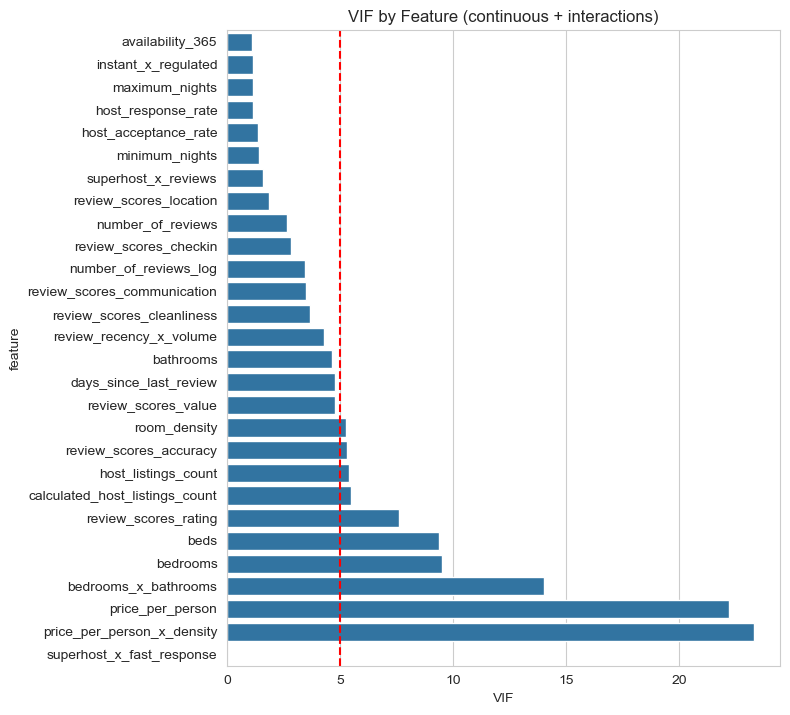

In [51]:
# Focus on continuous + interaction features for multicollinearity
interaction_features = ['superhost_x_reviews', 'price_per_person_x_density', 
                       'instant_x_regulated', 'bedrooms_x_bathrooms',
                       'review_recency_x_volume', 'superhost_x_fast_response']

# Only keep columns that are actually in X (numeric)
corr_cols = [c for c in (continuous_features + interaction_features) if c in X.columns]

# Correlation matrix
corr = X[corr_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.3)
plt.title('Correlation Heatmap – Continuous & Interaction Features')
plt.show()

# VIF for the same subset (to detect strong multicollinearity)
X_vif = X[corr_cols].copy()
X_vif = sm.add_constant(X_vif)

vif_df = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})

print(vif_df.sort_values('VIF', ascending=False))

# Optional: barplot of VIFs
plt.figure(figsize=(8, max(4, 0.25*len(vif_df))))
sns.barplot(
    data=vif_df[vif_df['feature'] != 'const'].sort_values('VIF', ascending=True),
    x='VIF', y='feature'
)
plt.axvline(5, color='red', linestyle='--')
plt.title('VIF by Feature (continuous + interactions)')
plt.tight_layout()
plt.show()


VIFs (multicollinearity)

price_per_person and price_per_person_x_density have VIF ≈ 22–23, and bedrooms_x_bathrooms has VIF ≈ 14, which indicates serious multicollinearity for these predictors.​

bedrooms and beds (VIF ≈ 9–9.5) show high but slightly less severe multicollinearity; most other variables have VIF < 5, which is usually acceptable.​

superhost_x_fast_response with VIF = NaN means that column is perfectly collinear (e.g., constant or linear combo of others) and should be dropped from the OLS design matrix.